In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import matplotlib.pyplot as plt
import numpy as np
from hw_1_optimization import plot_levels, plot_trajectory

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

- Домашнее задание выполняется в этом же Jupyter Notebook'e. Можно использовать Google Colab, но прислать нужно выгруженный `.ipynb` ноутбук.

- В названии файла укажите свои фамилию и имя

- Решение каждой задачи/пункта задачи поместите после условия.

- В финальной версии, которая будет отправлена на проверку, должны быть удалены все отладочные артефакты. Под таким артефактами подразумеваются любые выводы ячеек, которые никак не прокоментированы в тексте, а также любой массовый/длинный технический вывод.

- При чистом перезапуске ноутбука (*Run -> Restart Kernel and Run All Cells* или *Kernel -> Restart & Run All* в юпитере) все ячейки должны выполняться без ошибок.


## Пример запуска метода.

### Градиентный спуск в невыпуклом случае.

Будем минимизировать функцию Розенброка - это хорошо известная (невыпуклая) функция для сравнения алгоритмов оптимизации

Двумерная функция Розенброка выглядит так
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Rosenbrock_function.svg/1920px-Rosenbrock_function.svg.png" width="500"/>
</div>


Минимум функции Розенброка находится в $x^* = (1, \ldots, 1)^\top$, значение функции в минимуме равно нулю.

Реализуем градиентный спуск с постоянным шагом. Шаг грубо (с точостью до порядка) подберём руками - перебором найдём наибольшую степень десятки, при которой метод ещё сходится (не улетает на бесконечность).

Чтобы нарисовать графики сходимости, на каждой итерации будем сохранять норму градиента, значение функции, расстояние до решения и текущую итерацию (на практике мы решения не знаем, но на тестовой задаче можем вычислить и эту метрику).

In [132]:
from scipy.optimize import rosen, rosen_der
from typing import Callable


def gd(f: Callable, df: Callable, x0: np.ndarray, x_star: np.ndarray, h: float, iters: int, use_armijo: bool = False) -> tuple:
    x = x0.copy()
    grad_log, func_log, dist_log = [np.empty(iters) for _ in range(3)]
    iter_log = np.empty((iters, x0.shape[0]))
    for i in tqdm(range(iters)):
        grad = df(x)
        grad_log[i], func_log[i], dist_log[i], iter_log[i] = (
            np.linalg.norm(grad),
            f(x),
            np.linalg.norm(x - x_star),
            x.copy(),
        )
        if use_armijo:
            phi = lambda a: f(x - a * grad)
            der_phi = lambda a: -grad @ df(x - a * grad)
            h = armijo(phi, der_phi, previous_alpha=h)
        x -= h * grad
            
    return x, grad_log, func_log, dist_log, iter_log


def nesterov(
    f: Callable,
    df: Callable,
    x0: np.ndarray,
    x_star: np.ndarray,
    h: float,
    momentum: float,
    iters: int,
) -> tuple:
    x = x0.copy()
    y = x0.copy()
    grad_log, func_log, dist_log = [np.empty(iters) for _ in range(3)]
    iter_log = np.empty((iters, x0.shape[0]))
    for i in tqdm(range(iters)):
        grad = df(y)
        grad_log[i], func_log[i], dist_log[i], iter_log[i] = (
            np.linalg.norm(grad),
            f(x),
            np.linalg.norm(x - x_star),
            x.copy(),
        )

        x_old = x.copy()
        x = y - h * grad
        y = x + momentum * (x - x_old)

    return x, grad_log, func_log, dist_log, iter_log

In [133]:
dim = 2
rosen_solution = np.ones(dim)

x0 = np.zeros(dim)  # начальная точка

_, _, _, _, iter_log_gd = gd(f=rosen, df=rosen_der, x0=x0, x_star=rosen_solution, h=2 * 1e-3, iters=1000)
_, _, _, _, iter_log_nesterov = nesterov(
    f=rosen, df=rosen_der, x0=x0, x_star=rosen_solution, h=2 * 1e-3, momentum=0.9, iters=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

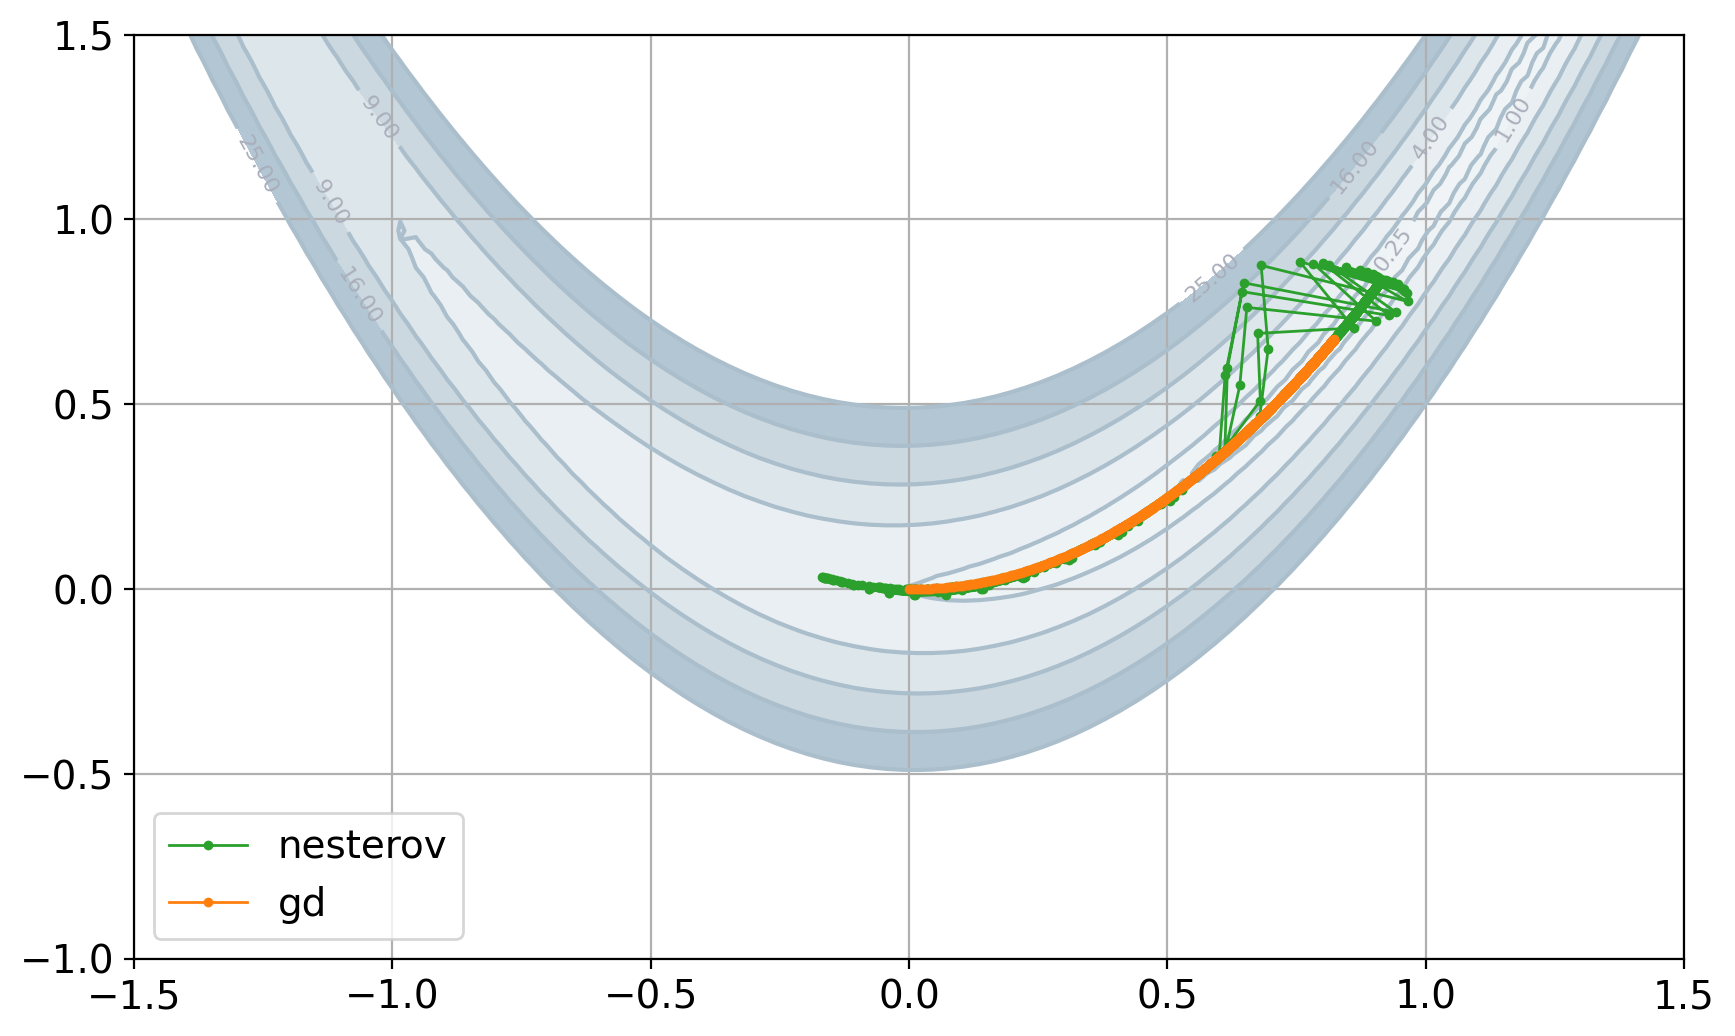

In [134]:
plot_levels(func=rosen, xrange=[-1.5, 1.5], yrange=[-1, 1.5])
plot_trajectory(history=iter_log_nesterov, color="C2", label="nesterov")
plot_trajectory(history=iter_log_gd, label="gd")

## 1. Траектории градиентных методов на двумерной квадратичной функции.

Рассмотрим траекторию градиентного метода на двумерной квадратичной функции вида
$$
f(x) = \frac12 x^\top A x,
$$
где $A\in\mathbb{S}_{++}^n$ -- симметричнач положительно определенная матрица $2\times 2$. Проверьте, что константа гладкости $f$ равна $L = \lambda_{\max}(A)$, а константа сильной выпуклости равна $\mu = \lambda_{\min}(A)$.

Функция ```generate_random_2d_psd_matrix``` создает случайную матрицу с заданными собственными числами. Функция ```armijo``` вычисляет размер шага по правилу Армихо.

**Задание**.

1. Задайте квадратичную функцию и ее градиент.

1. Меняя число обусловленности матрицы, запускайте из одной и той же точки градиентный метод с постоянным шагом, с выбором шага по Армихо и метод Нестерова. Измерьте количество итераций до достижения заданной точности (по аргументу). Также изобразите траектории с помощью ```plot_trajectory```. Сравните и объясните результаты. Размер шага задавайте методом проб и ошибок.

**Замечание**. Здесь придется переписать функцию ```gd``` из введения так, чтобы можно было задавать шаг по условию Армихо. Также, для ускорения линейного поиска, можно передавать функции ```armijo``` размер шага, вычисленный на предыдущей итерации.

3. Задайте размер шага для градиентного спуска и метода Нестерова согласно теории (шаг $1/L$). Происходят ли теперь осцилляции траектории метода? Объясните результат.

1.

$\nabla f = Ax $

$\nabla^2 f = A \Rightarrow L = \max \lambda(A), \mu = \min \lambda(A) $, тк A - положительно определенная.

In [135]:
from hw_1_optimization import generate_random_2d_psd_matrix, armijo

from tqdm.notebook import tqdm 

2.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

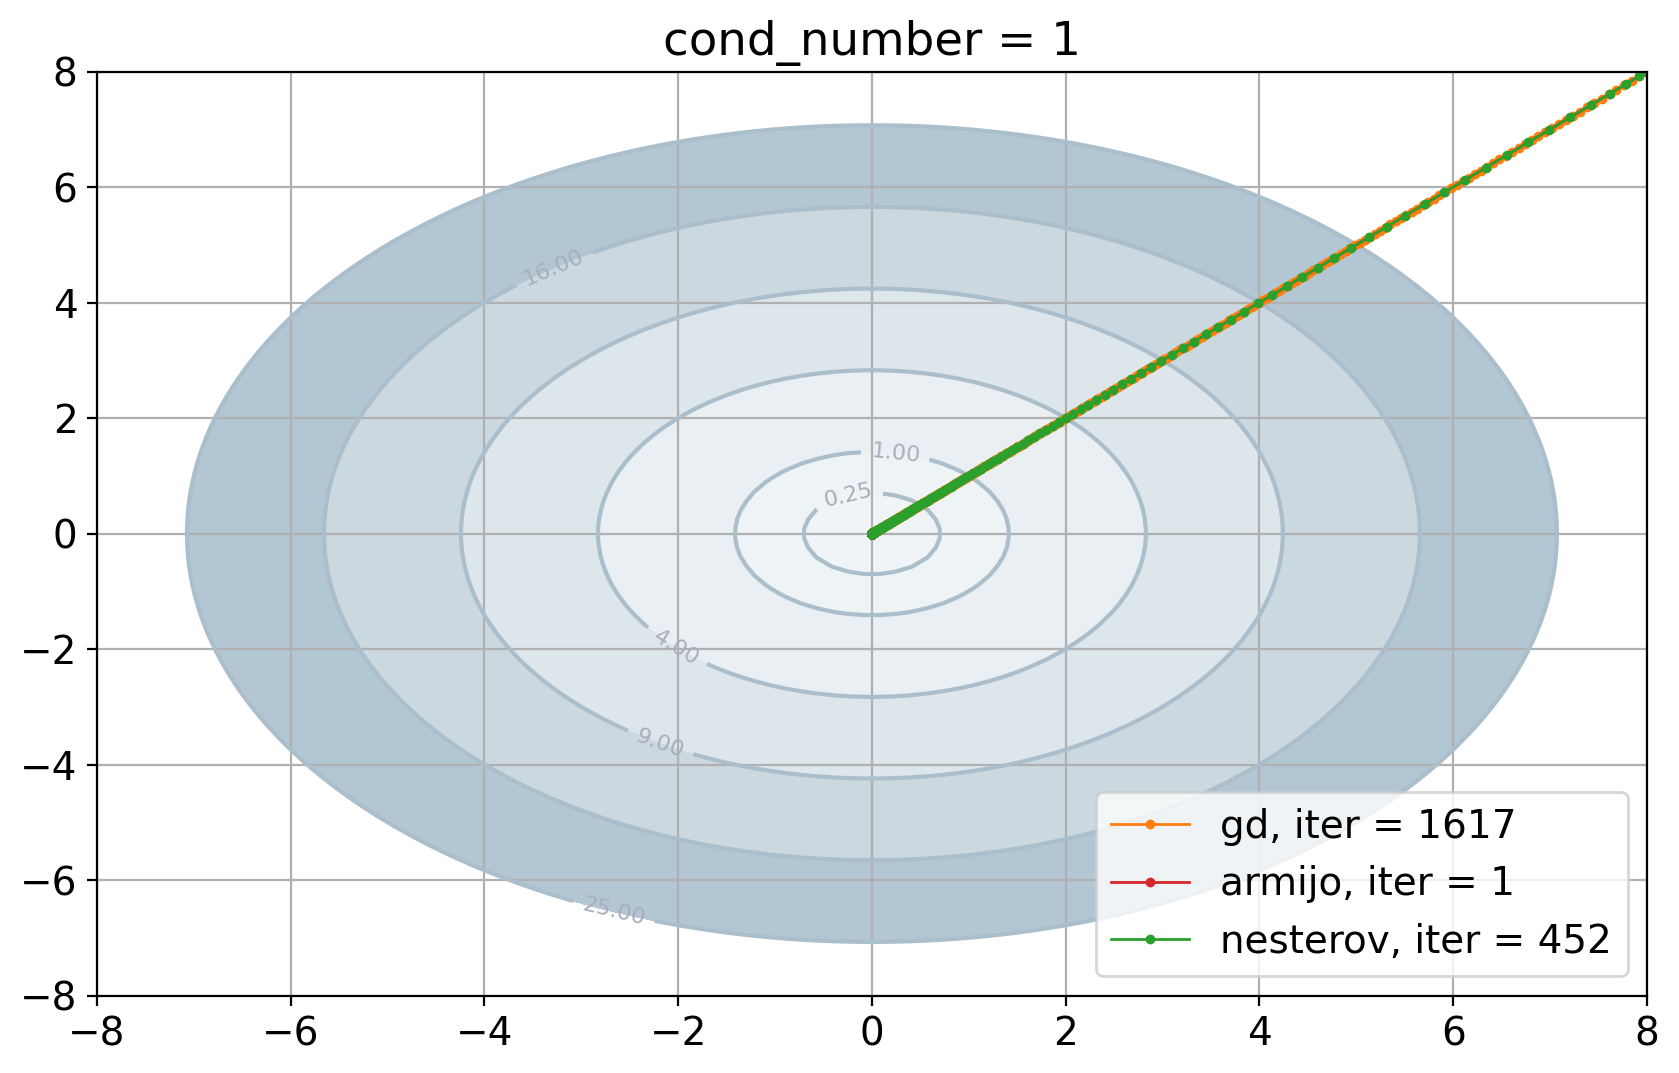

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

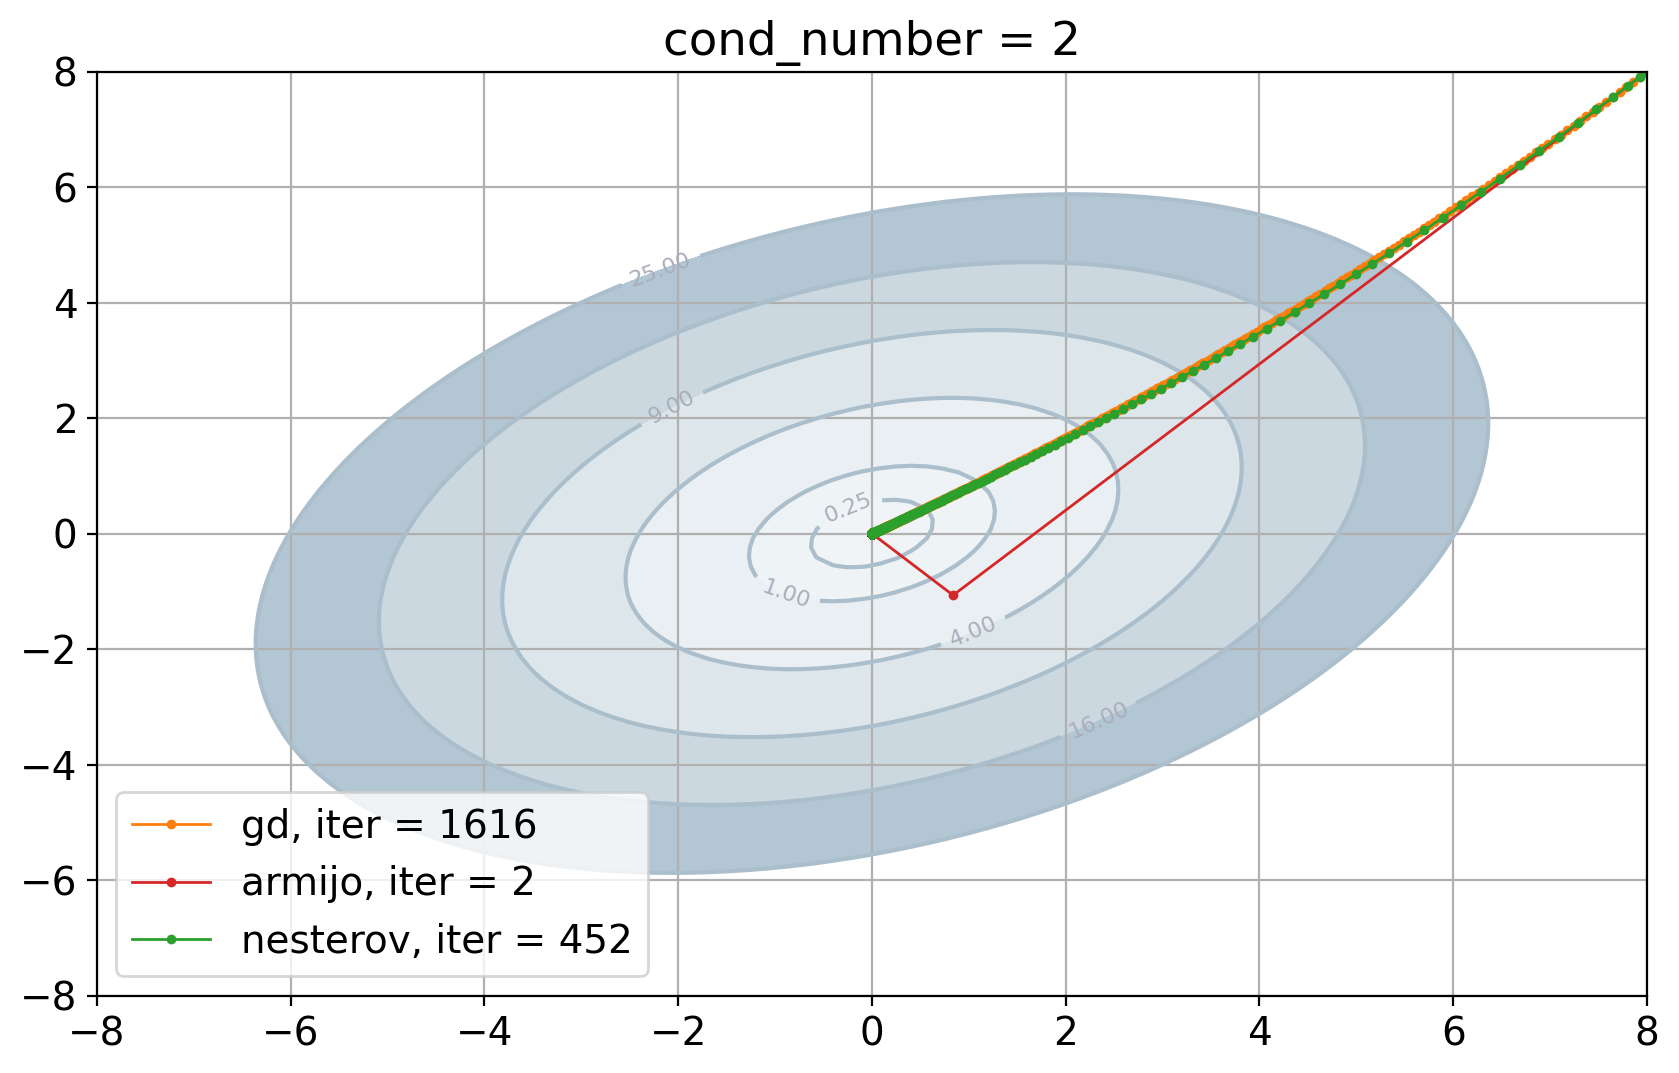

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

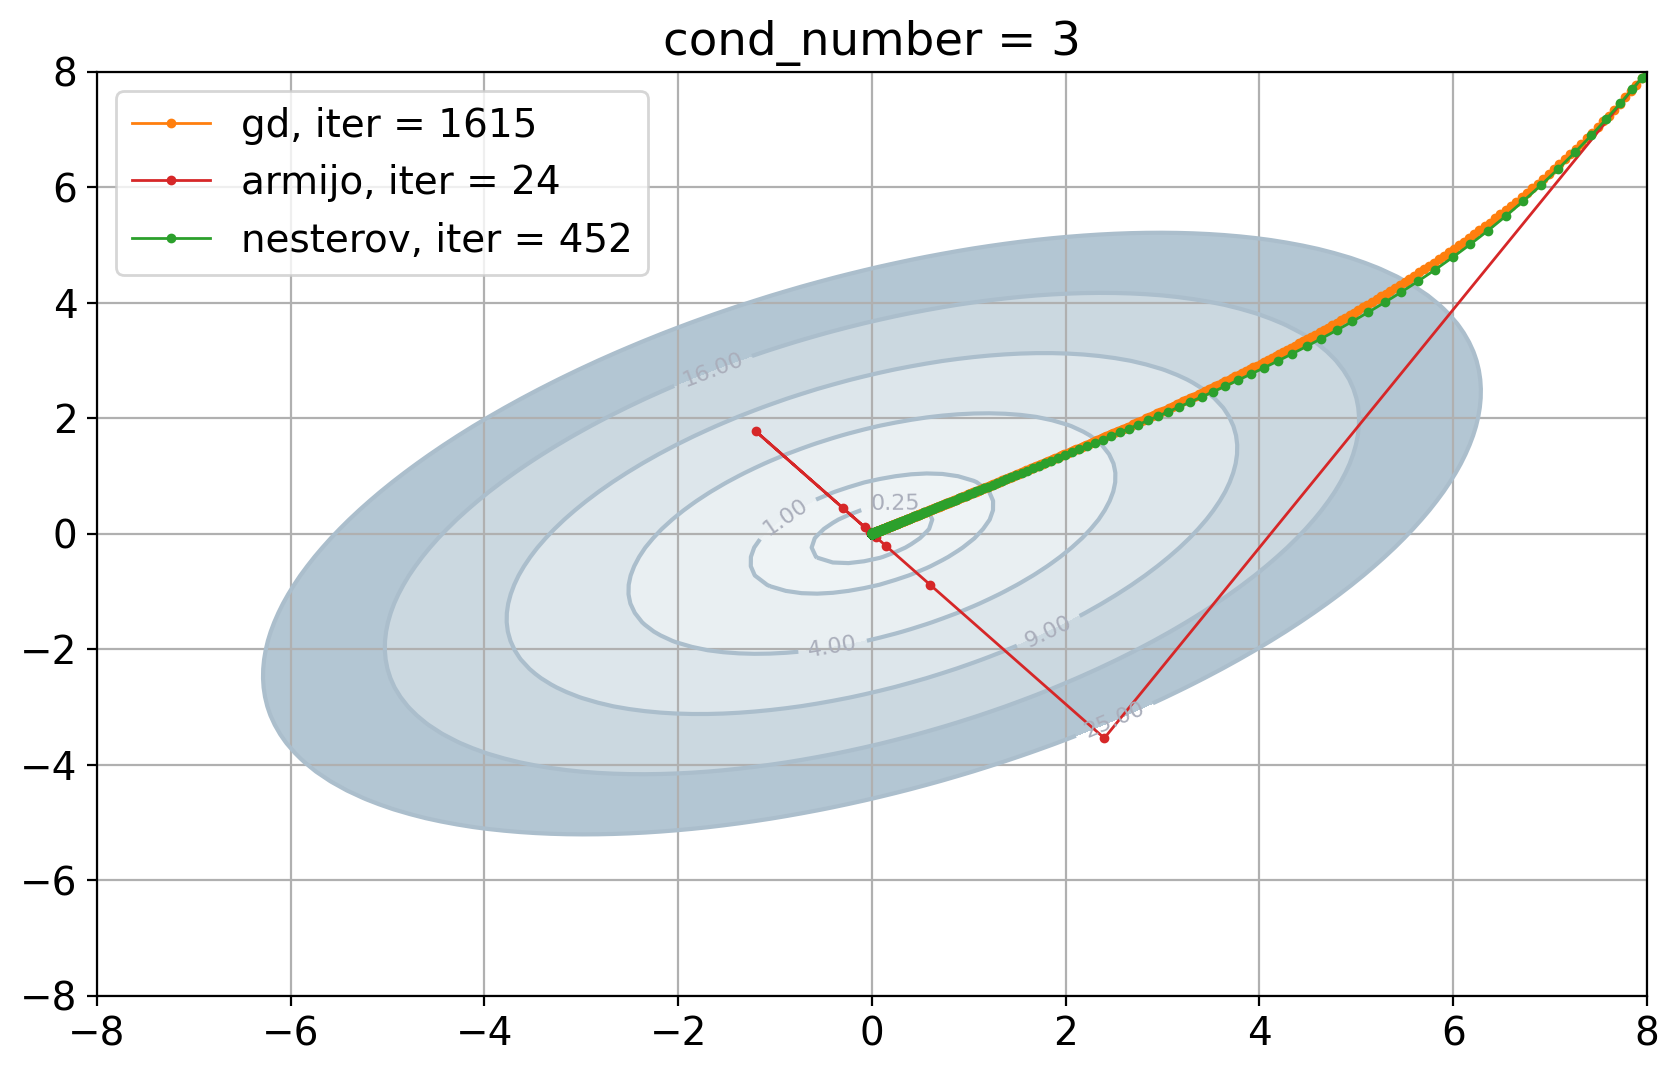

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

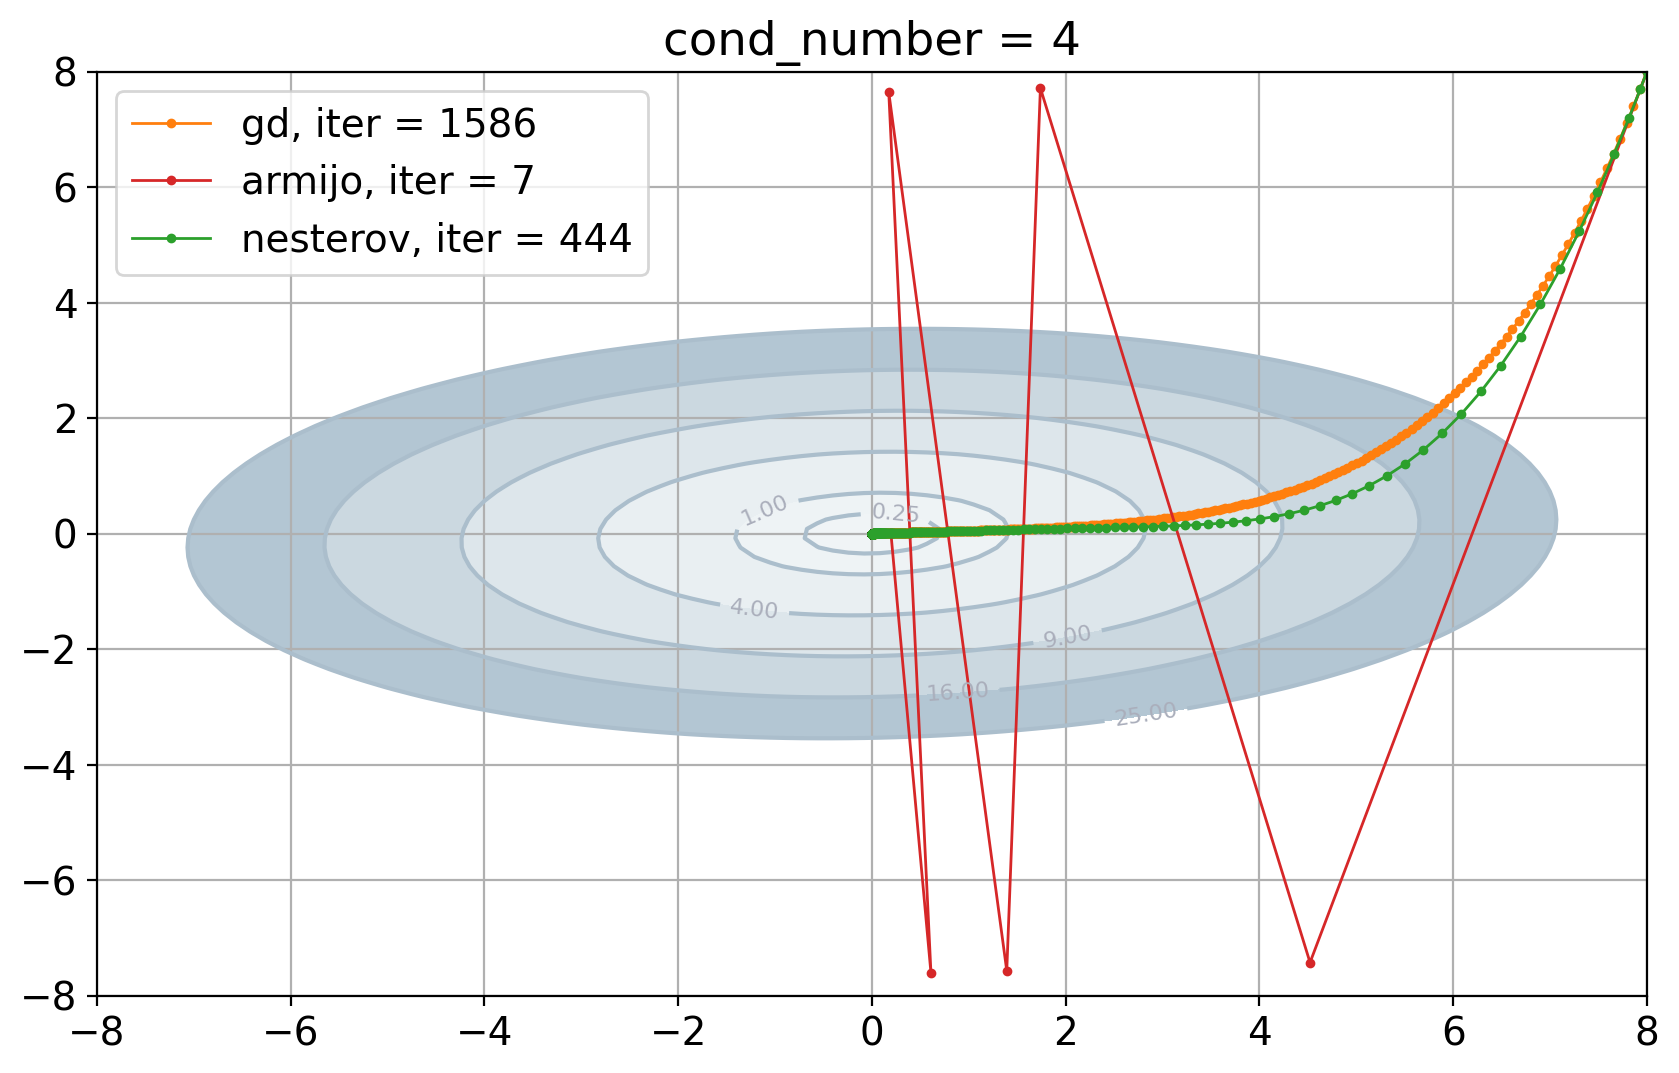

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

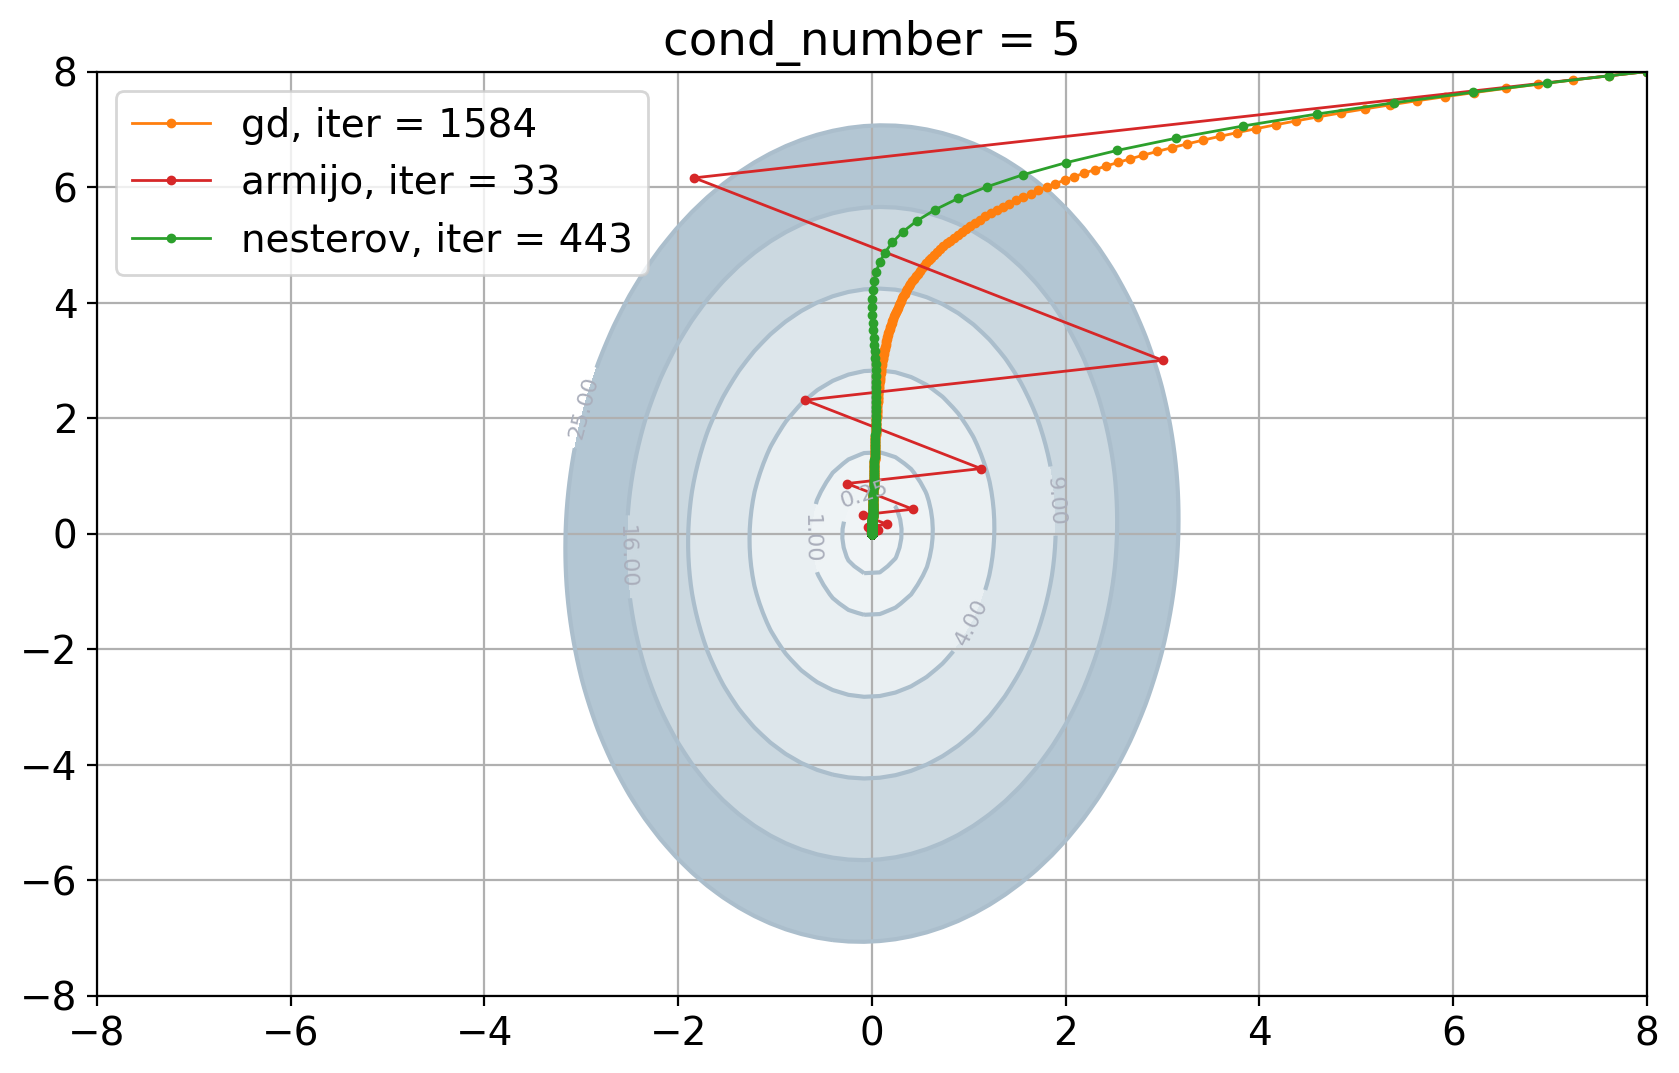

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

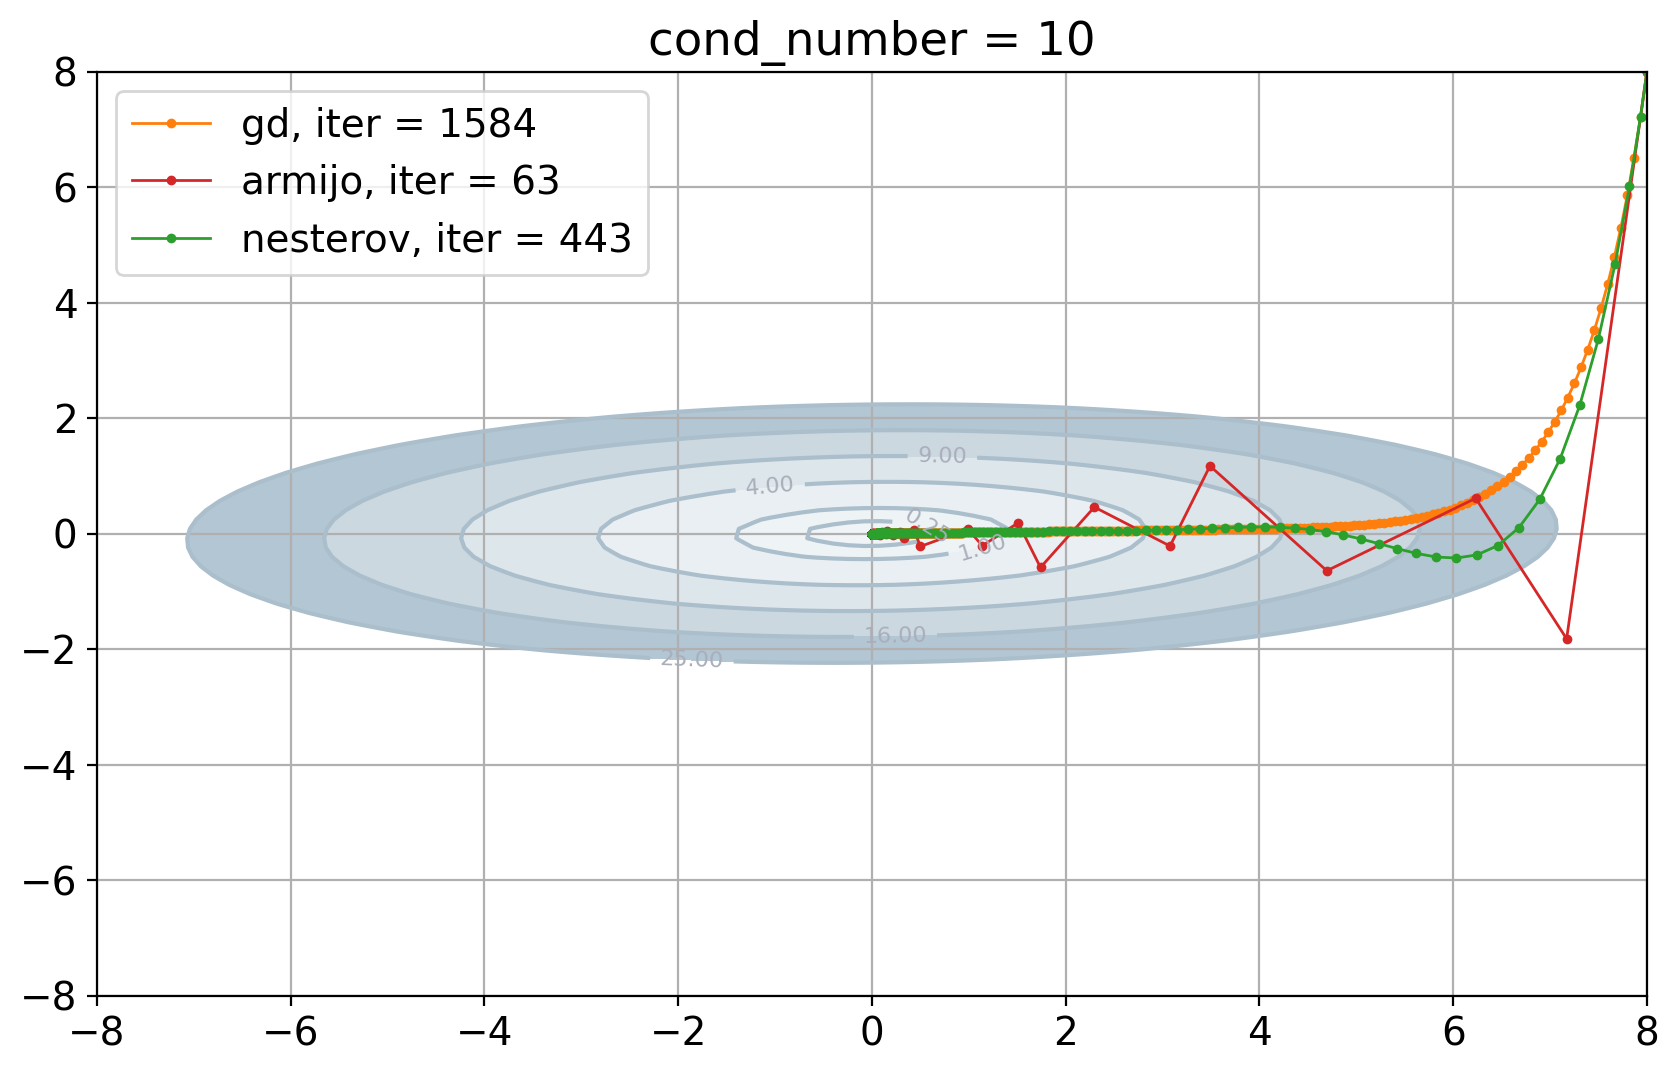

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

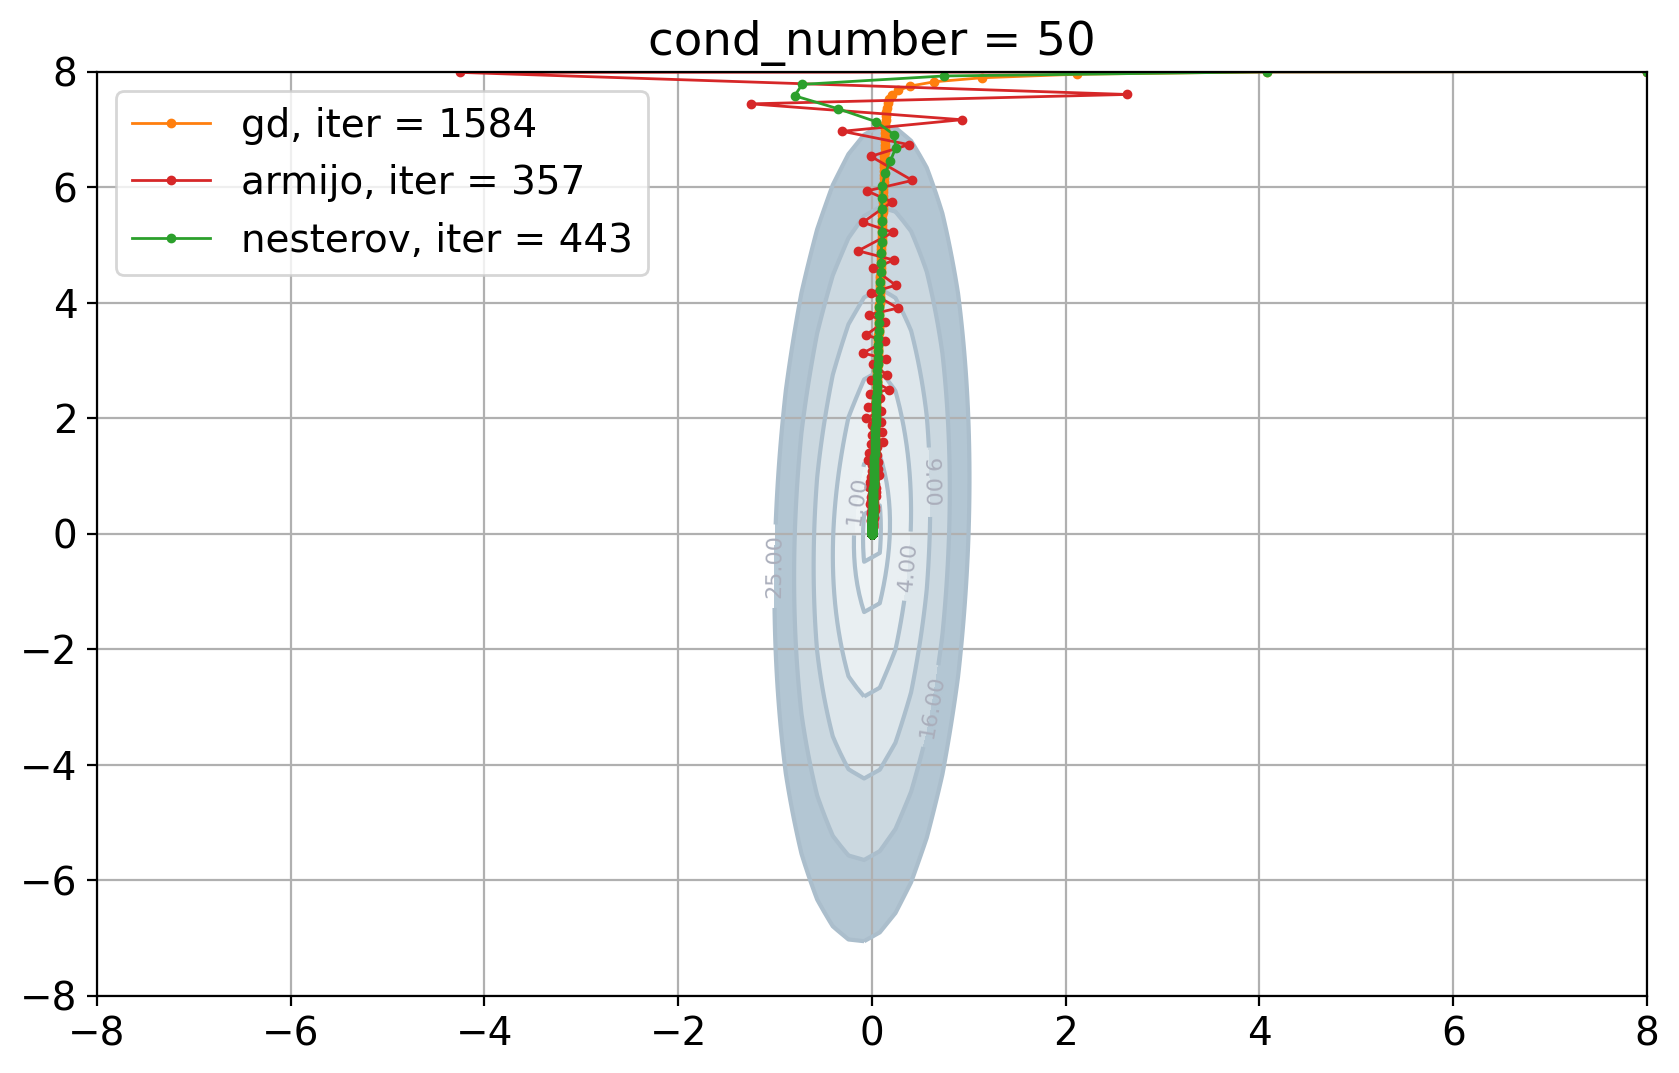

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

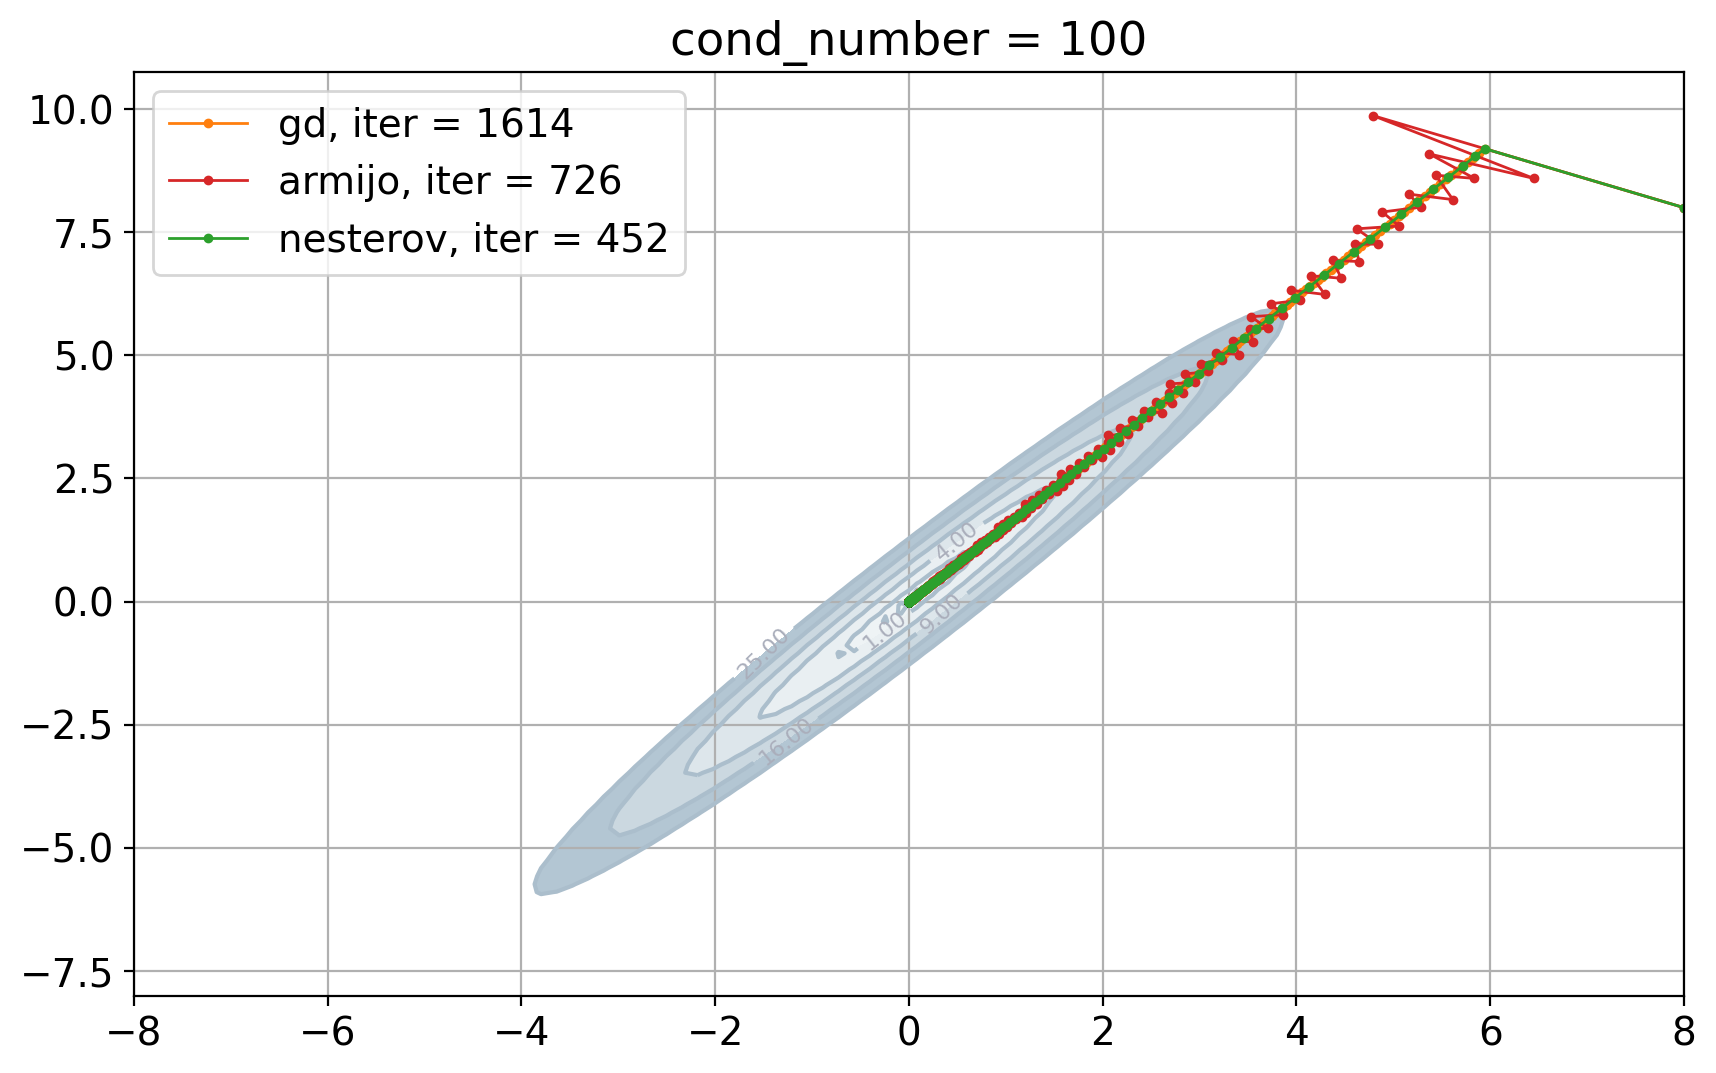

Среднее количество итераций до достижения eps в ГД с константным шагом: 1614.0
Среднее количество итераций до достижения eps в ГД с шагом Армихо: 726.0
Среднее количество итераций до достижения eps в методе Нестерова: 452.0


In [136]:
lr = 1e-2
x0 = np.ones(2) * 8
x_star = np.zeros(2)
eps = 1e-6
iters = 10000
n_experiments = 100

cond_numbers = [1, 2, 3, 4, 5, 10, 50, 100]

for cond_number in cond_numbers:
    A = generate_random_2d_psd_matrix(1, cond_number)
    def f(x):
        x = np.array(x)
        return 0.5 * x.T @ A @ x

    def df(x):
        x = np.array(x)
        return A @ x
    _, _, _, dist_const_arg, iter_log_gd_const_lr = gd(f, df, x0, x_star, lr, iters)
    _, _, _, dist_armijo, iter_log_gd_armijo = gd(f, df, x0, x_star, lr, iters, armijo)
    _, _, _, dist_nesterov, iter_log_nesterov = nesterov(f, df, x0, x_star, lr, 0.7, iters)

    const_arg_eps_iter = np.argmax(dist_const_arg < eps)
    armijo_eps_iter = np.argmax(dist_armijo < eps)
    nesterov_eps_iter = np.argmax(dist_nesterov < eps)
    
    plot_levels(func=f, xrange=[-8, 8], yrange=[-8, 8])
    plot_trajectory(history=iter_log_gd_const_lr, label=f"gd, iter = {const_arg_eps_iter}")
    plot_trajectory(history=iter_log_gd_armijo, label=f"armijo, iter = {armijo_eps_iter}", color="C3")
    plot_trajectory(history=iter_log_nesterov, color="C2", label=f"nesterov, iter = {nesterov_eps_iter}")
    plt.title(f"cond_number = {cond_number}")
    plt.legend()
    plt.show()

print(f'Среднее количество итераций до достижения eps в ГД с константным шагом: {np.mean([const_arg_eps_iter for _ in range(n_experiments)])}')
print(f'Среднее количество итераций до достижения eps в ГД с шагом Армихо: {np.mean([armijo_eps_iter for _ in range(n_experiments)])}')
print(f'Среднее количество итераций до достижения eps в методе Нестерова: {np.mean([nesterov_eps_iter for _ in range(n_experiments)])}')

Видно, что правило Армихо позволяет находить минимум за пару итераций, если число обусловленности небольшое, причем работает оно даже лучше Нестерова.

Мы видим, что качество ГД и Нестерова немного ухудшается с увеличением числа обусловленности. Так же мы пронаблюдали, что при достаточно большом числе обусловленности метод Нестерова оказался лучше ГД с шагом Армихо.

Мы видим, что если начальная точка не лежит близко к большей оси эллипса то методы начинают очень сильно осциллировать.

3.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

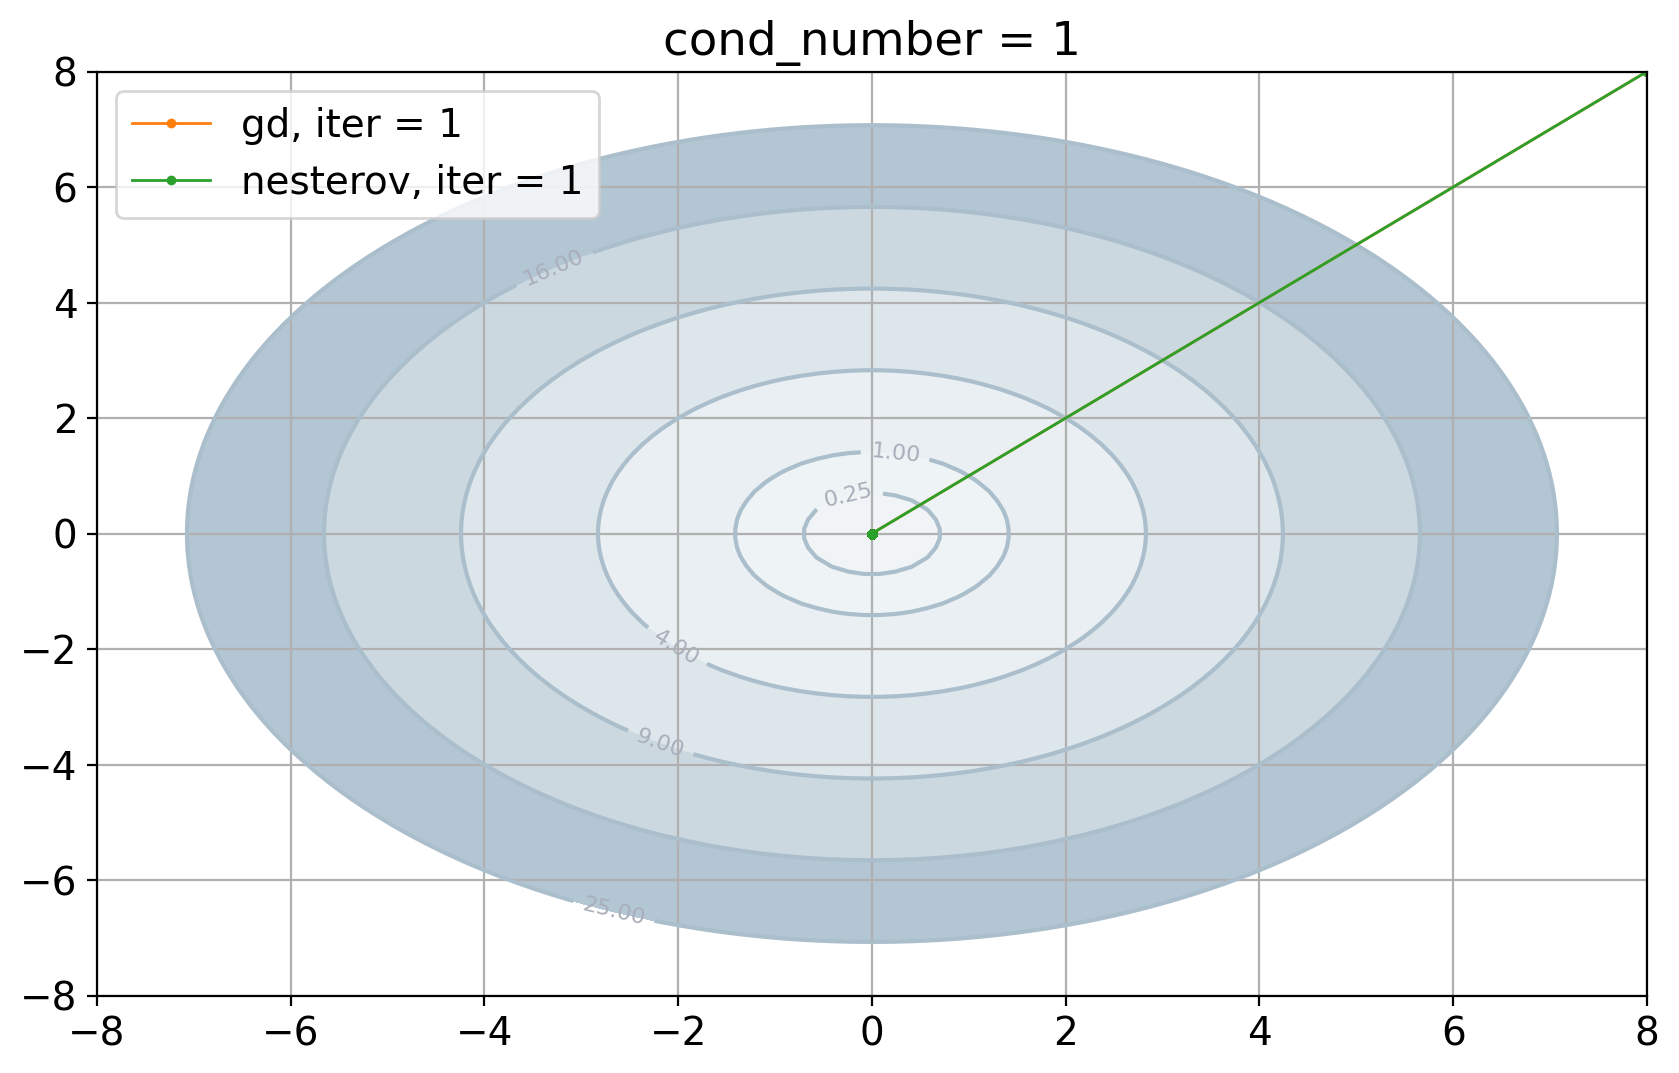

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

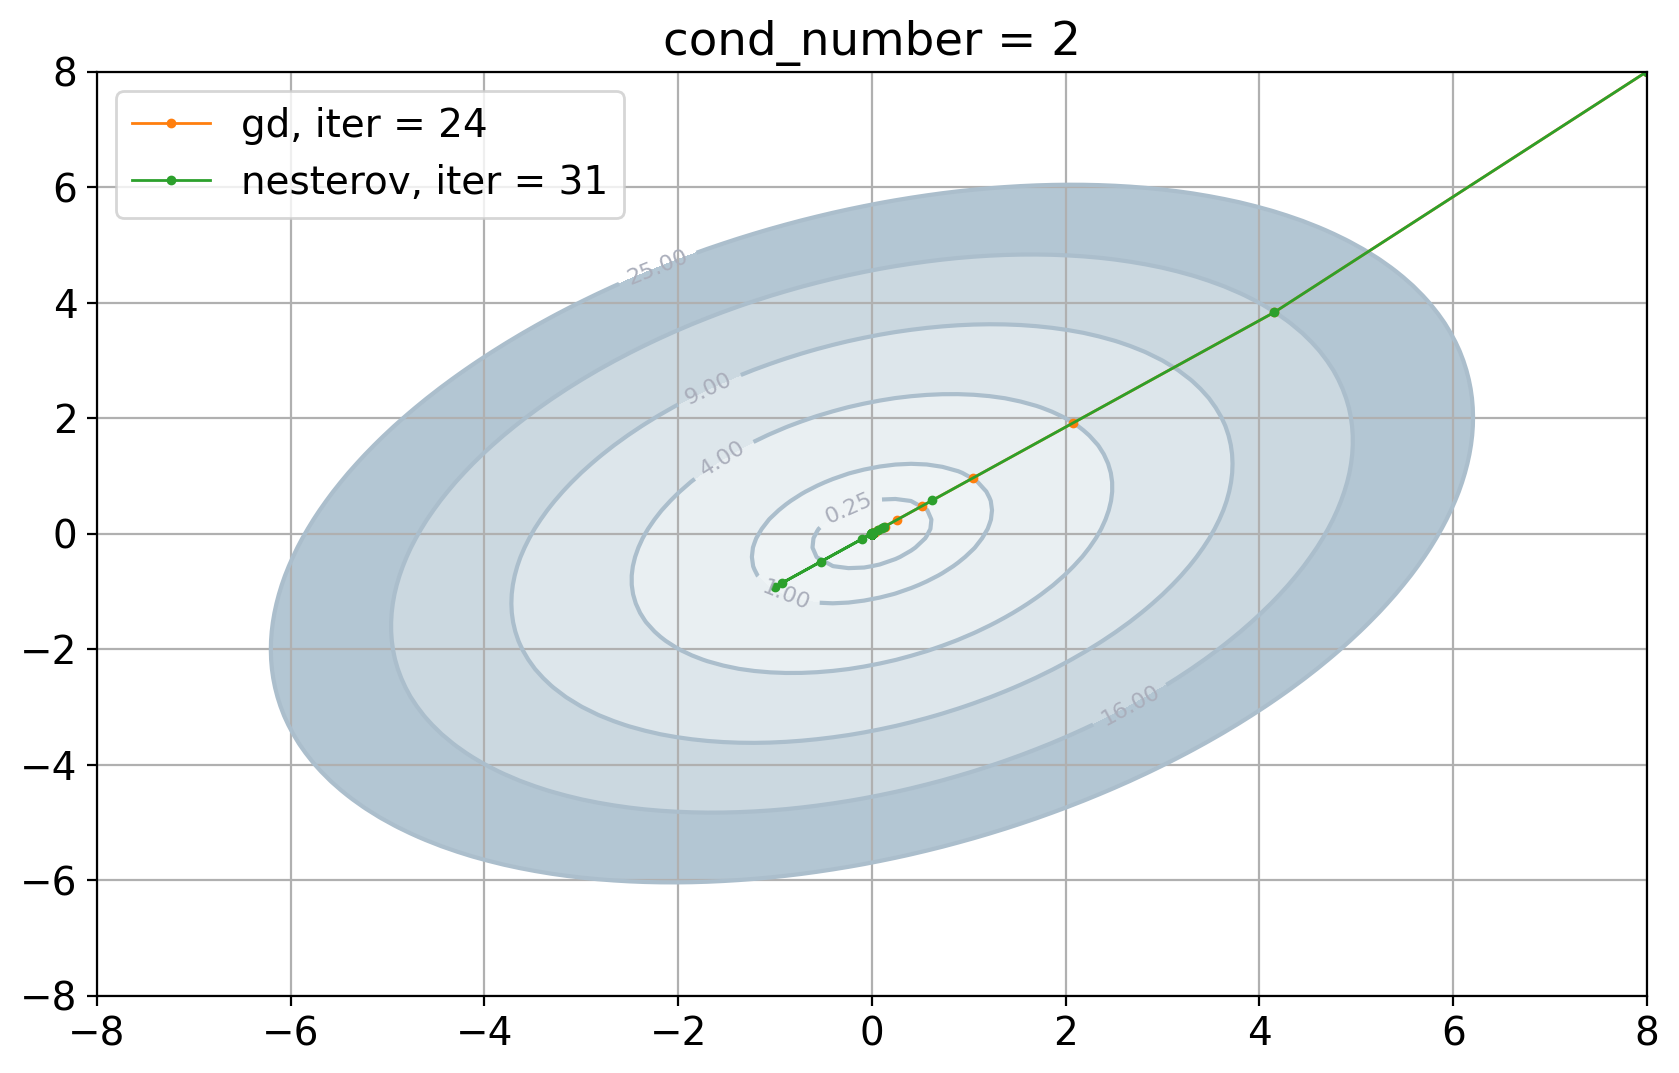

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

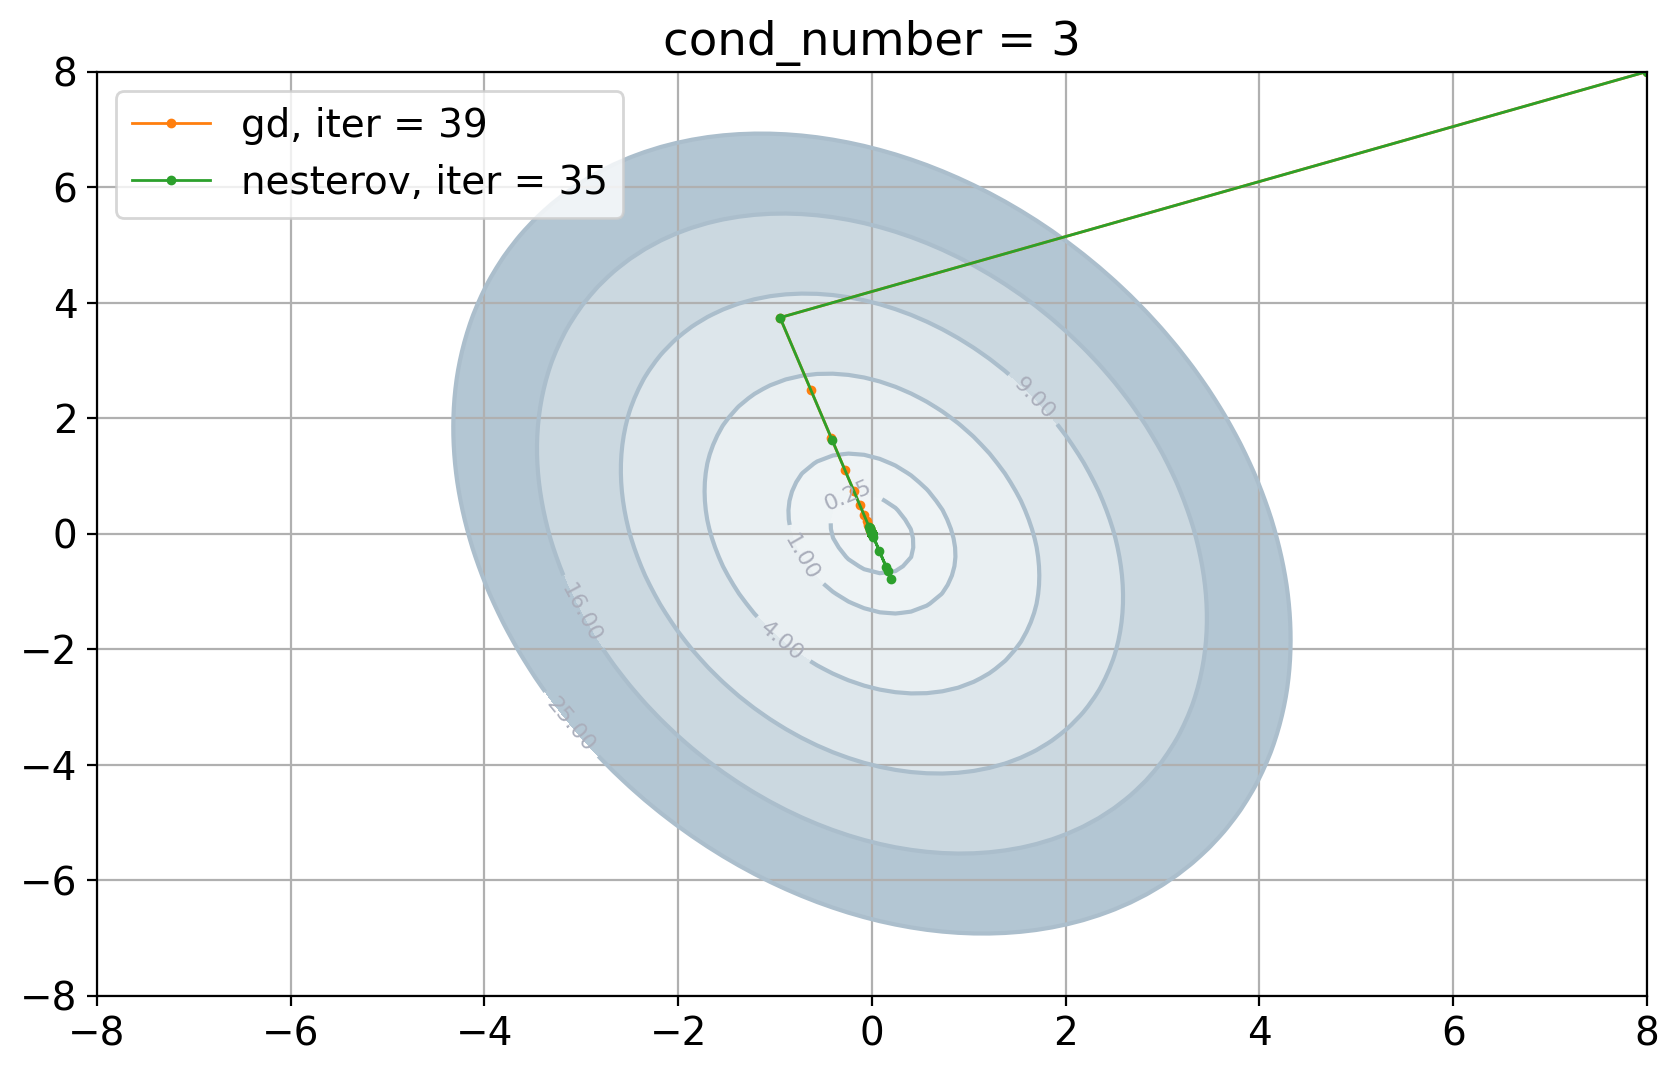

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

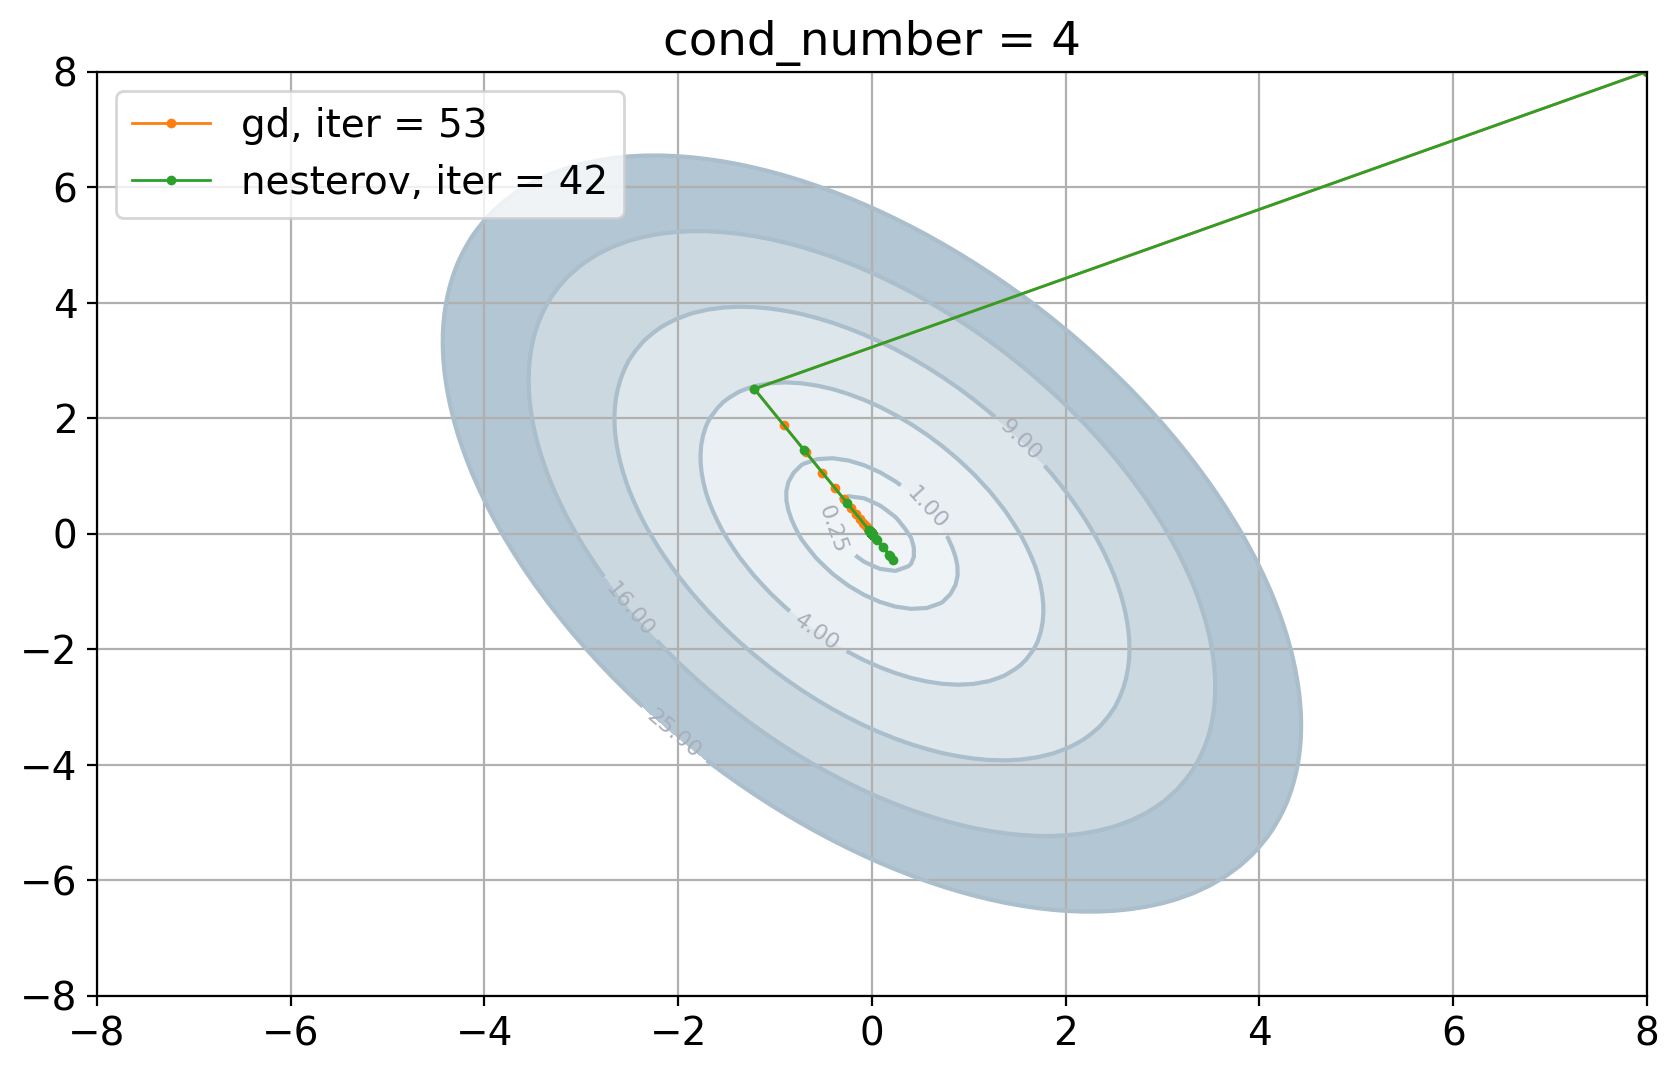

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

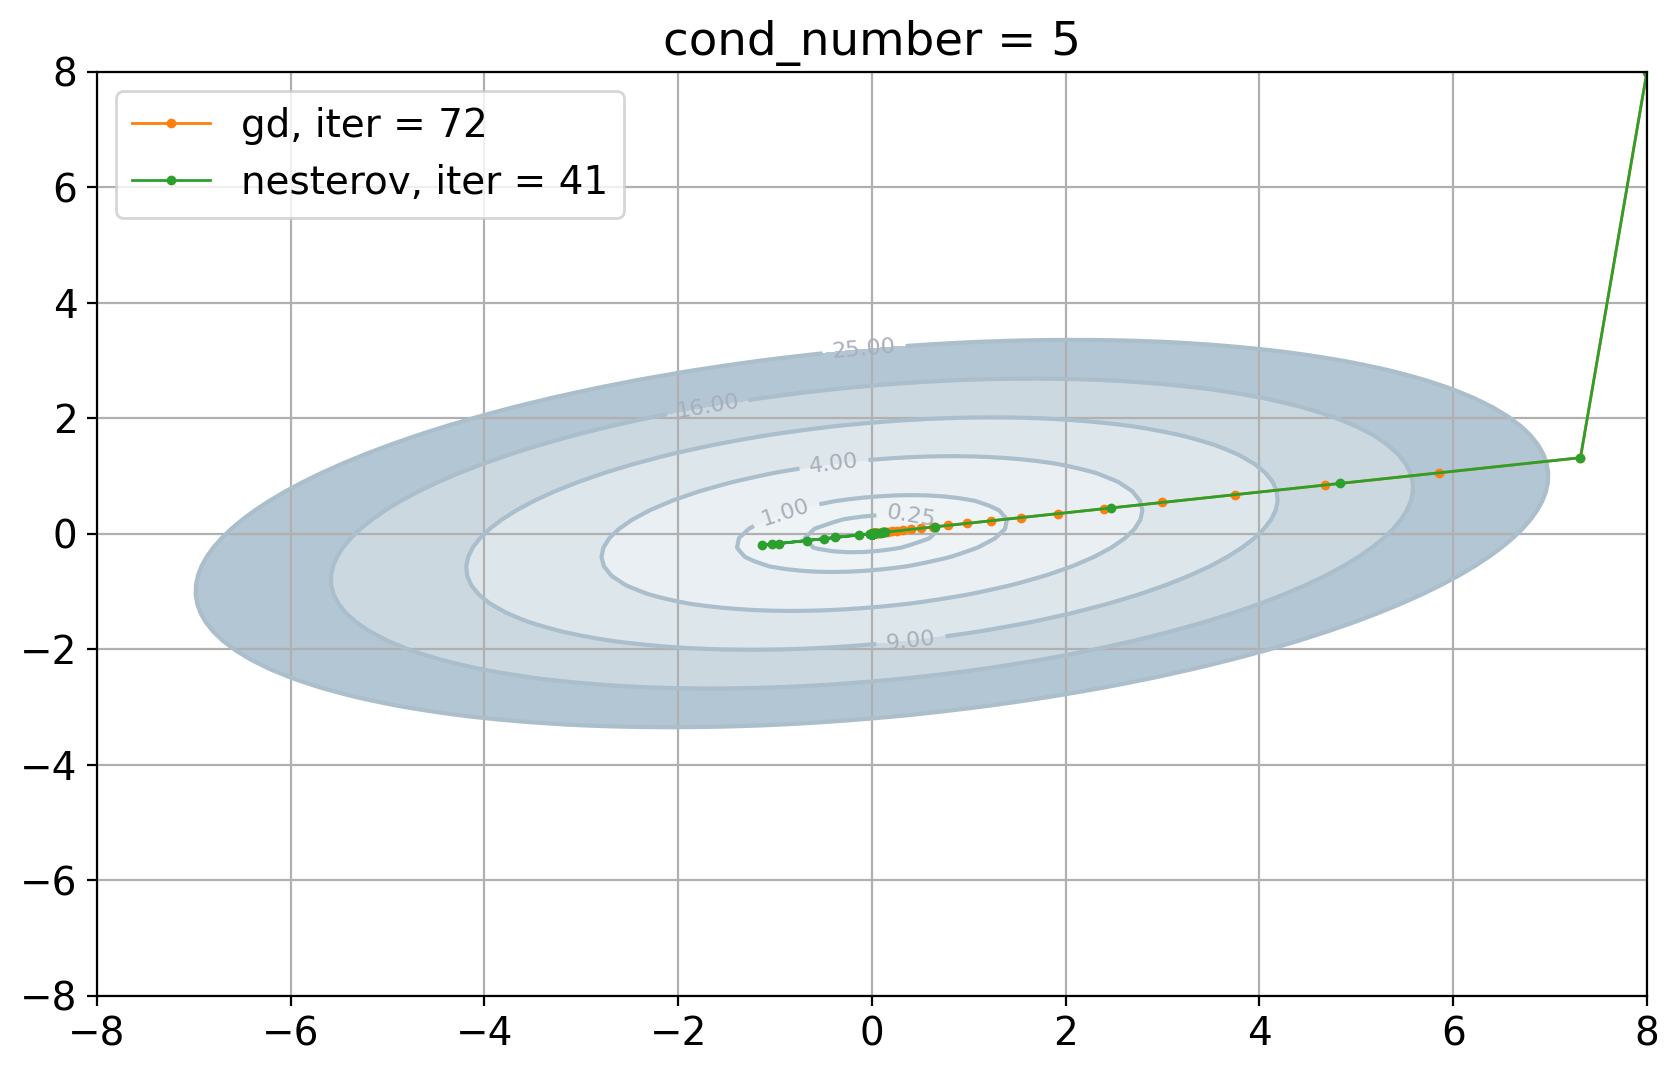

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

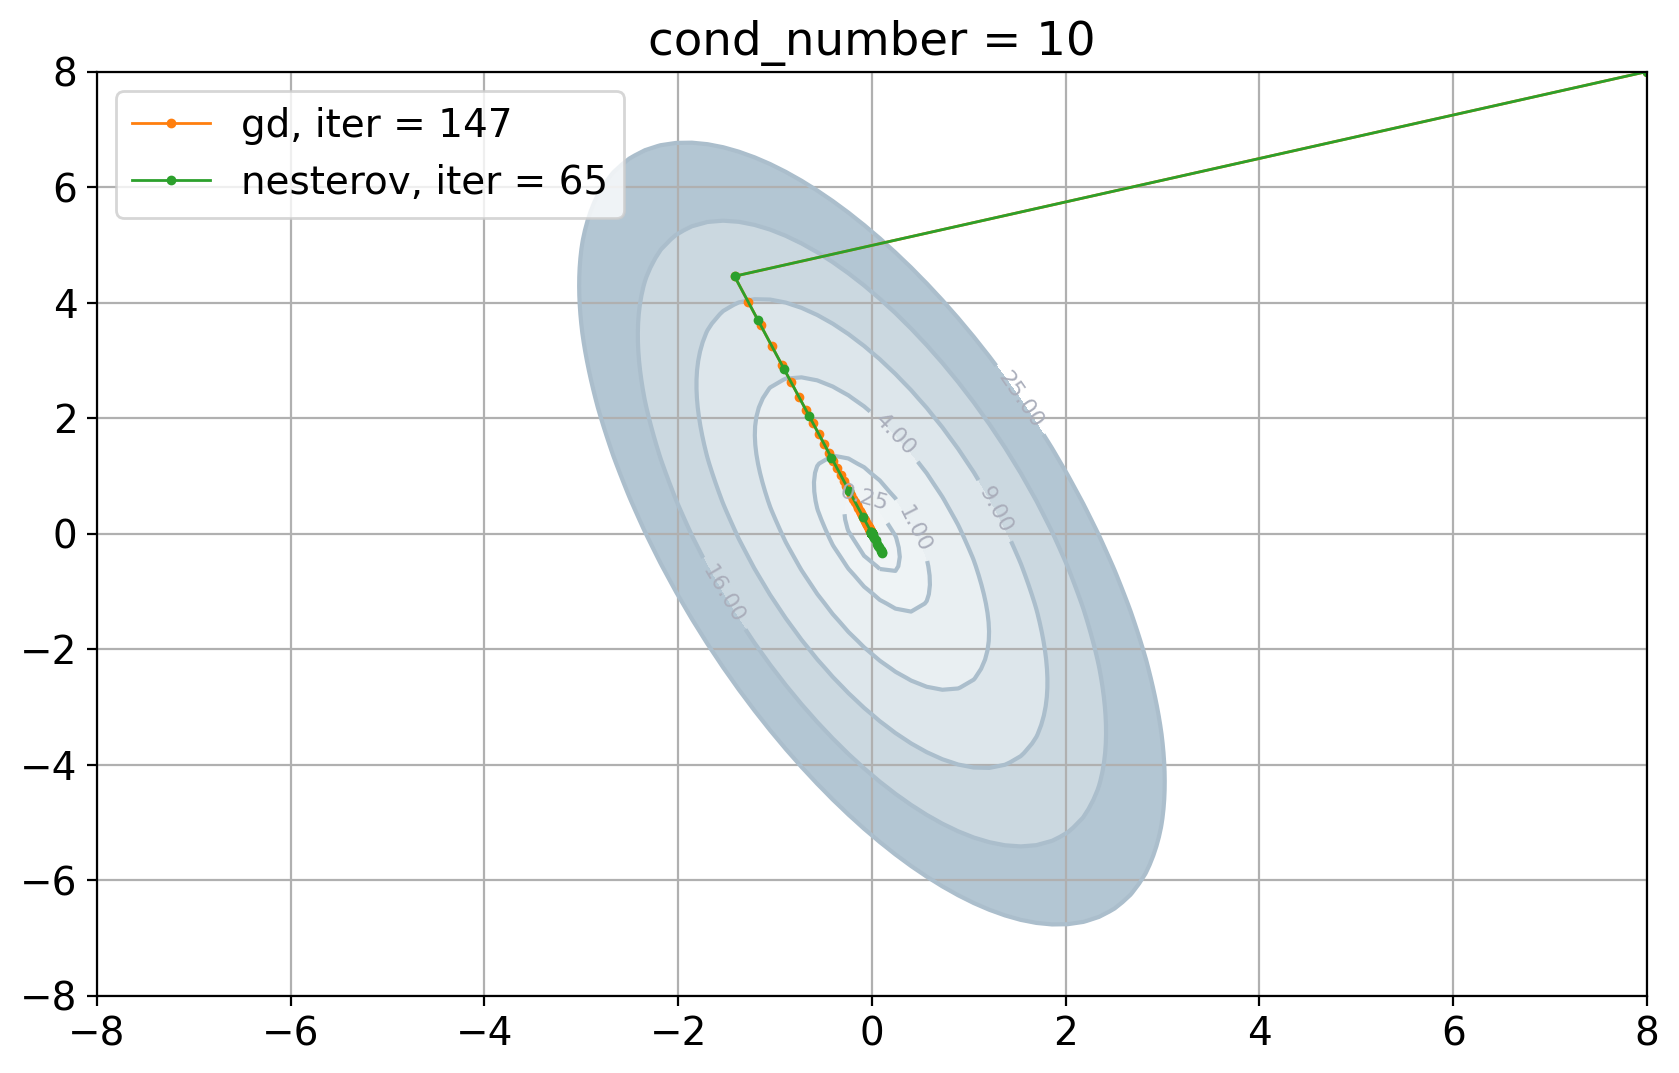

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

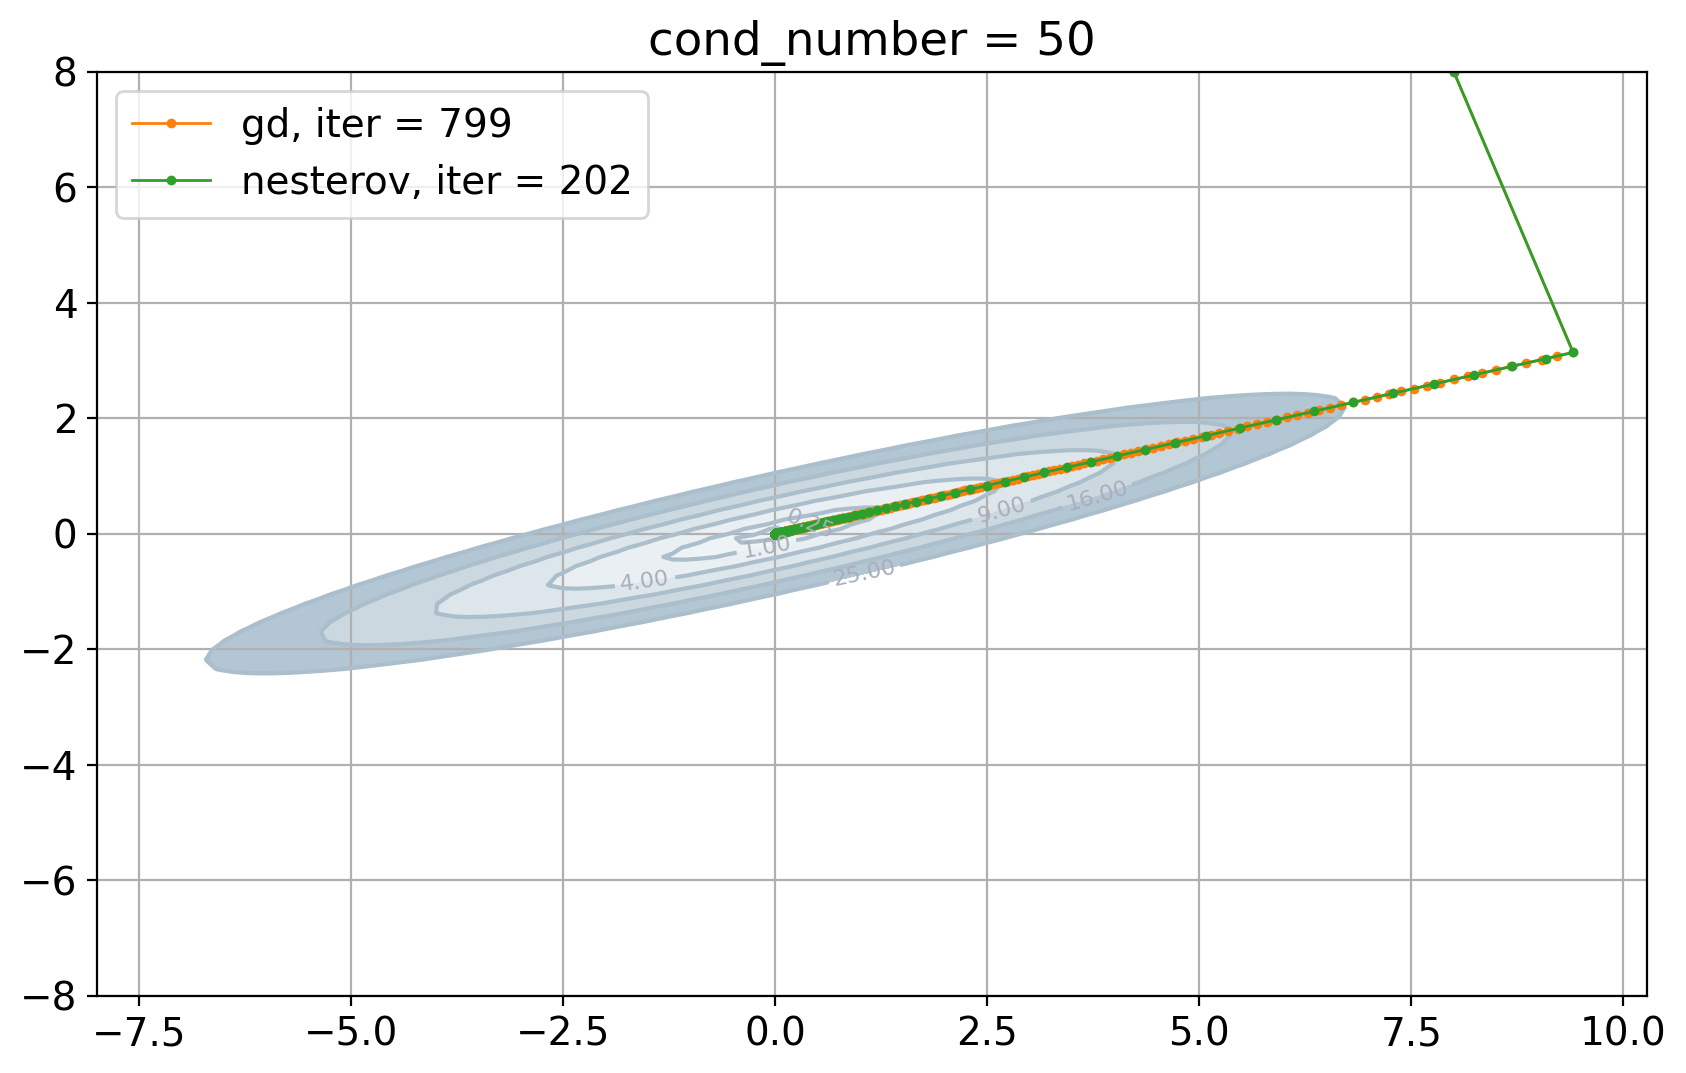

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

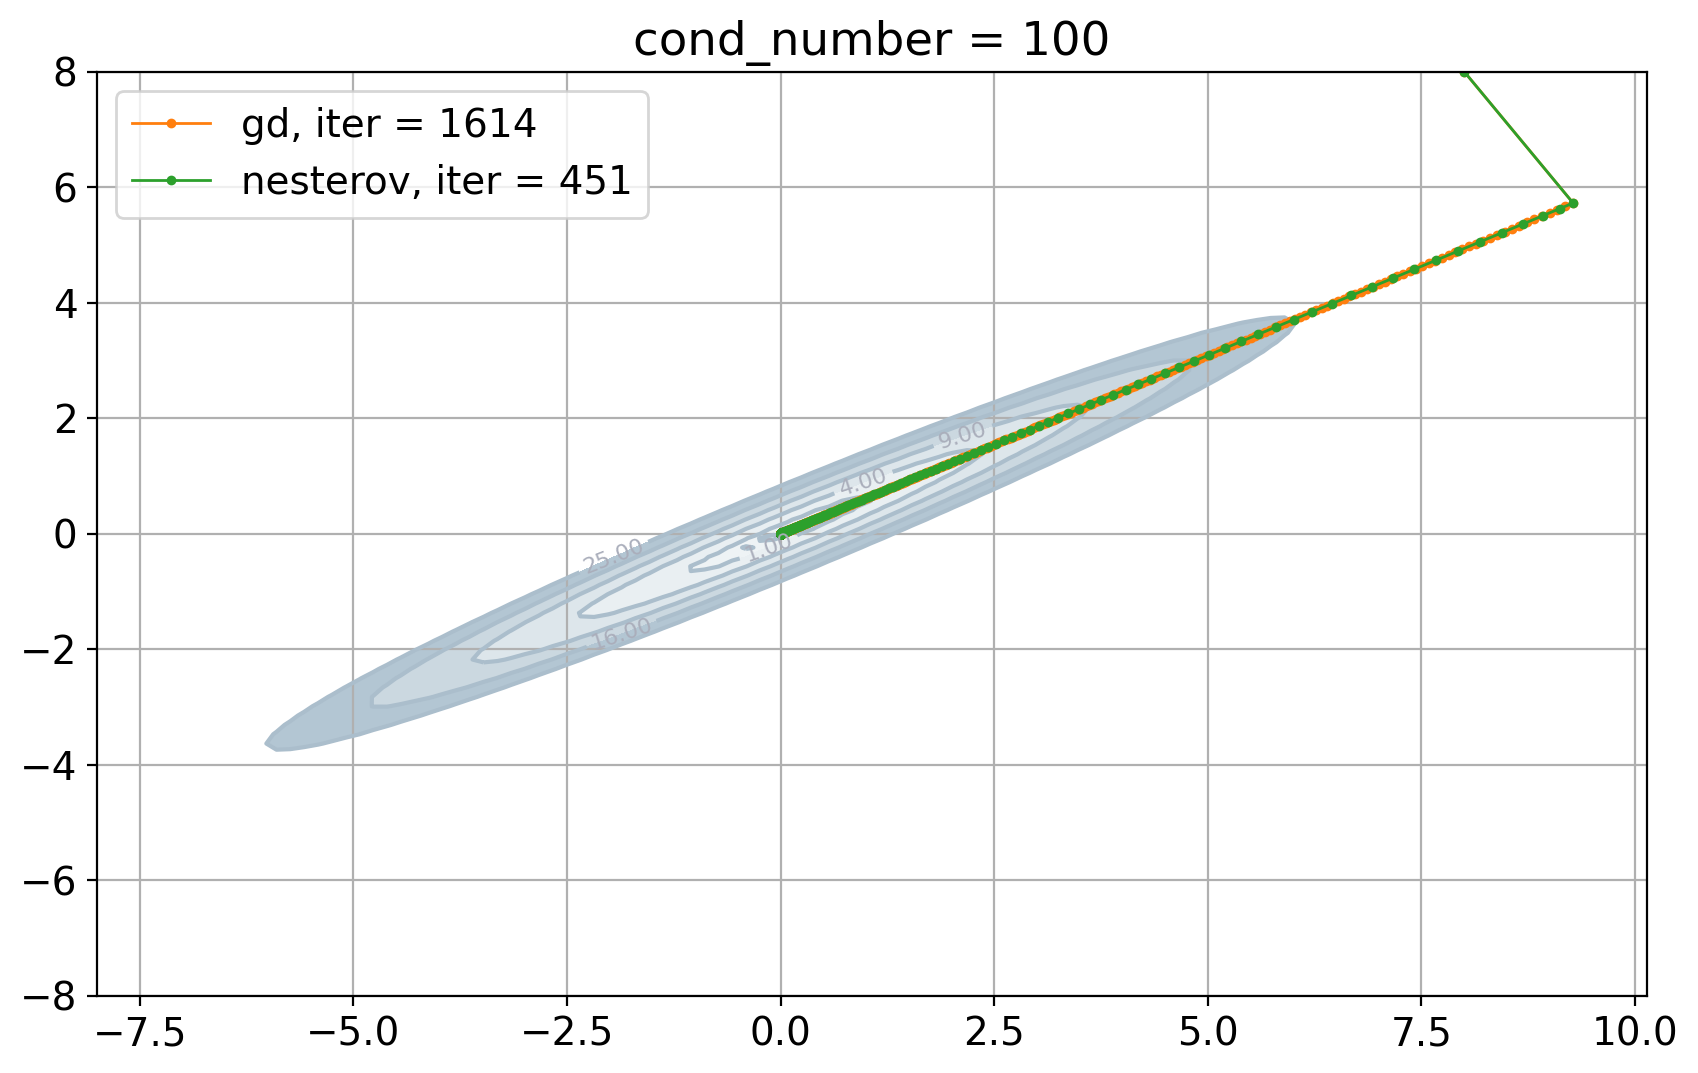

Среднее количество итераций до достижения eps в ГД с константным шагом: 1614.0
Среднее количество итераций до достижения eps в методе Нестерова: 451.0


In [137]:
for cond_number in cond_numbers:
    A = generate_random_2d_psd_matrix(1, cond_number)
    def f(x):
        x = np.array(x)
        return 0.5 * x.T @ A @ x

    def df(x):
        x = np.array(x)
        return A @ x
    _, _, _, dist_const_arg, iter_log_gd_const_lr = gd(f, df, x0, x_star, 1 / cond_number, iters)
    _, _, _, dist_nesterov, iter_log_nesterov = nesterov(f, df, x0, x_star, 1 / cond_number, 0.7, iters)

    const_arg_eps_iter = np.argmax(dist_const_arg < eps)
    nesterov_eps_iter = np.argmax(dist_nesterov < eps)
    
    plot_levels(func=f, xrange=[-8, 8], yrange=[-8, 8])
    plot_trajectory(history=iter_log_gd_const_lr, label=f"gd, iter = {const_arg_eps_iter}")
    plot_trajectory(history=iter_log_nesterov, color="C2", label=f"nesterov, iter = {nesterov_eps_iter}")
    plt.title(f"cond_number = {cond_number}")
    plt.legend()
    plt.show()

print(f'Среднее количество итераций до достижения eps в ГД с константным шагом: {np.mean([const_arg_eps_iter for _ in range(n_experiments)])}')
print(f'Среднее количество итераций до достижения eps в методе Нестерова: {np.mean([nesterov_eps_iter for _ in range(n_experiments)])}')

Подбор правильного шага 1/L позволил сократить количество итераций  при небольшом числе обусловленности.

Также почти полностью пропали осцилляции при небольшом числе обусловленности если начальная точка находится далеко от большей оси эллипса.

## 2. Эффективность градиентных методов в зависимости от числа обусловленности.

Из теории известно, что градиентному спуску нужно $O(\kappa \ln(1/\varepsilon))$ итерация для достижения точности $\varepsilon$, а методу Нестерова - $O(\sqrt\kappa \ln(1/\varepsilon))$, где $\kappa = L/\mu$ - число обусловленности функции. Задача это пункта - измерить данные зависимости на примере. Воспользуйтесь функцией ```generate_random_psd_matrix``` для генерации матрицы с нужным числом обусловленности.

**Задание**.

1. Запускайте градиентный спуск и метод Нестерова с теоретически заданными параметрами на задачах с разным числом обусловленности. Постройте график зависимости числа итераций до достижения нужной точности от числа обусловленности в двойном логарифмическом масштабе. Согласуется ли график с теорией?

**Замечание**. Не сохраняйте историю итераций метода, т.к. это займет слишком много памяти. Измените соответствующее место в функции ```gd```.

In [138]:
def gd_light(f: Callable, df: Callable, x0: np.ndarray, x_star: np.ndarray, h: float, eps: float) -> tuple:
    x = x0.copy()
    iters = 0
    while np.linalg.norm(x - x_star) > eps:
        grad = df(x)
        x -= h * grad
        iters += 1
    return x, iters


def nesterov_light(
    f: Callable,
    df: Callable,
    x0: np.ndarray,
    x_star: np.ndarray,
    h: float,
    momentum: float,
    eps: float,
) -> tuple:
    x = x0.copy()
    y = x0.copy()
    iters = 0
    while np.linalg.norm(x - x_star) > eps:
        grad = df(y)
        x_old = x.copy()
        x = y - h * grad
        y = x + momentum * (x - x_old)
        iters += 1
                    
    return x, iters

  0%|          | 0/50 [00:00<?, ?it/s]

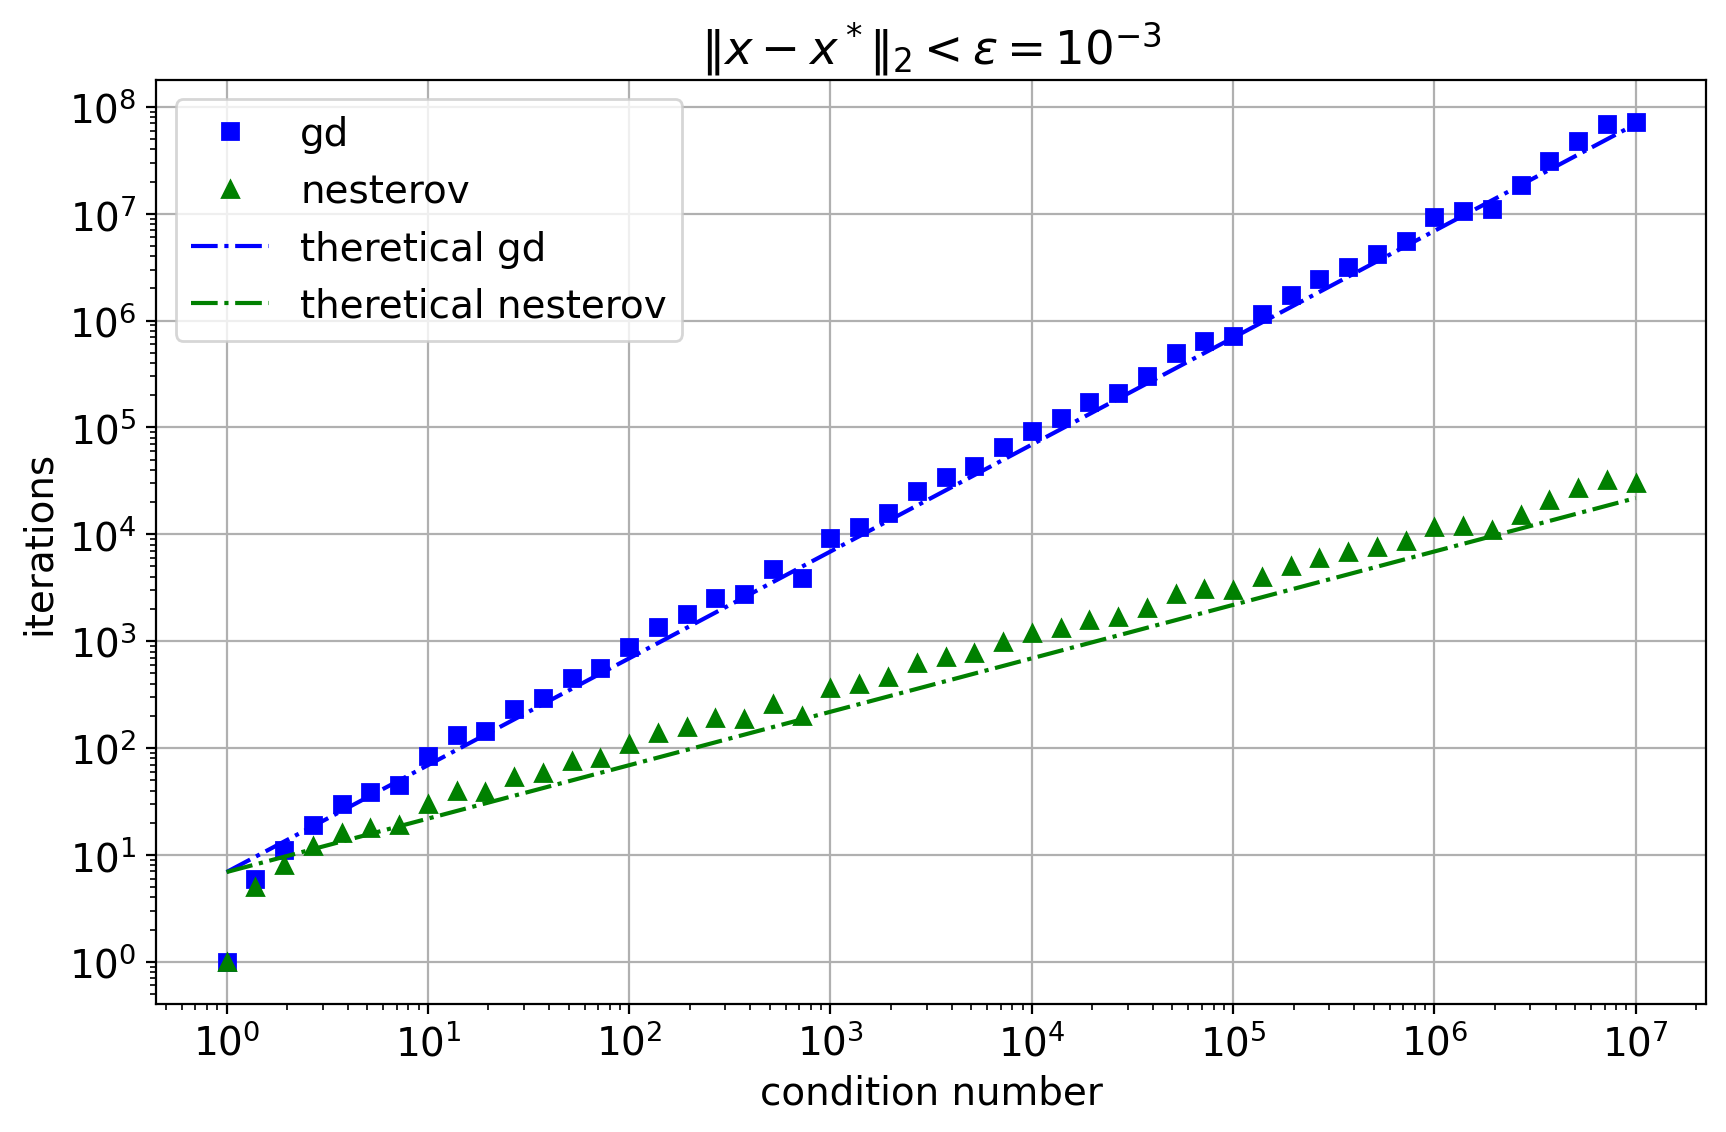

In [140]:
from hw_1_optimization import generate_random_psd_matrix

lr = 1e-2

eps = 1e-3
iters = 2000
cond_numbers = np.logspace(0, 7, 50)

iters_gd = []
iters_nesterov = []

for cond_number in tqdm(cond_numbers):
    dim = np.random.randint(2, 10)
    A = generate_random_psd_matrix(dim, 1, cond_number)
    x0 = np.ones(dim) * 8
    x_star = np.zeros(dim)
    def f(x):
        x = np.array(x)
        return 0.5 * x.T @ A @ x

    def df(x):
        x = np.array(x)
        return A @ x
    x, n_iter_gd = gd_light(f, df, x0, x_star, 1 / cond_number, eps)
    
    beta = (np.sqrt(cond_number) - 1) / (np.sqrt(cond_number) + 1)
    x, n_iter_nesterov = nesterov_light(f, df, x0, x_star, 1 / cond_number, beta, eps)
    
    iters_gd.append(n_iter_gd)
    iters_nesterov.append(n_iter_nesterov)

theretical_gd = cond_numbers * np.log(1 / eps)
theretical_nesterov = np.sqrt(cond_numbers) * np.log(1 / eps)

plt.figure(figsize=(10, 6))
plt.plot(cond_numbers, iters_gd, label="gd", marker="s", linestyle=" ", color="b")
plt.plot(cond_numbers, iters_nesterov, label="nesterov", marker="^", linestyle=" ", color="g")
plt.plot(cond_numbers, theretical_gd, label="theretical gd", linestyle="-.", color="b")
plt.plot(cond_numbers, theretical_nesterov, label="theretical nesterov", linestyle="-.", color="g")

plt.grid()
plt.xlabel("condition number")
plt.ylabel("iterations")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\|x - x^*\|_2 < \varepsilon = 10^{-3}$")
plt.legend()
plt.show()


Мы видим, что теоретическая оценка для ГД и Нестерова совпадает с практической.

## 3. Логистическая регрессия.

Задача [логистической регрессии](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) c $l_2$ регуляризацией
для бинарной классификации имеет вид

$
f(x) = \frac\alpha2 \|x\|_2^2 + \frac1m \sum_{i=1}^m \log (1 + \exp(- b_i \langle a_i, x \rangle)) \to \min_w
$

где $x$-вектор параметров модели, $a_i$ - вектор признаков $i$-го объекта, $b_i \in \{-1, 1 \}$ - метка класса $i$-го объекта. 

Скачиваем датасет (если команда выдаёт ошибку, можно руками скачать и положить файл `mushrooms.txt` в папку с ноутбуком).

In [141]:
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms
!wget "https://raw.githubusercontent.com/niquepolice/misc-files/refs/heads/master/mushrooms.txt" -O mushrooms.txt

--2025-04-30 07:29:42--  https://raw.githubusercontent.com/niquepolice/misc-files/refs/heads/master/mushrooms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K) [text/plain]
Saving to: ‘mushrooms.txt’

mushrooms.txt       100%[===================>] 859,09K  1,02MB/s    in 0,8s    

2025-04-30 07:29:44 (1,02 MB/s) - ‘mushrooms.txt’ saved [879712/879712]



In [142]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = 2 * y - 3  # map {1, 2} to {-1, 1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Задание**. 

1. Выпишите градиент и гессиан для данной задачи. Является ли задача выпуклой? А $\mu$ - сильно выпуклой? Покажите, как можно оценить $\mu$. Покажите, что константа гладкости может быть оценена как $L = \max_i (\|a_i\|_2^2 / 4)$, взяв гессиан функции и использовав факт, что $e^t/(1 + e^t)^2\leq 1/4$.

1. Пользуясь формулой для $L$, численно оцените константу Липшица градиента для обучающей части выборки `X_{train}`, `y_{train}`.

1. Реализуйте функцию логистической регрессии и ее градиент.

1. Задайте $\alpha \approx L / 1000$. Запустите метод градиентного спуска для минимизации лосса на обучающей выборке. Длину шага определите из теории, подставив туда полученное $L$. Постройте графики сходимости по норме градиента от номера итерации (стоит сделать порядка 5000 итераций). Используйте логарифмический масштаб по вертикальной оси, чтобы можно было оценить скорость сходимости метода в окрестности решения. Посчитайте accuracy на тестовой выборке.

1. Сравните градиентный метод с методом Нестерова с параметрами по теории и с методом с выбором шага по Армихо.

1. Сделайте то же самое для $\alpha = 0$. Что изменилось в графике сходимости?

1)

$$\nabla f(x) = \alpha x - \frac{1}{m} \sum_{i=1}^m  \frac{b_i a_i}{1 + \exp(-b_i \langle a_i, x \rangle)}$$

$$\nabla^2 f(x) = \alpha I + \frac{1}{m} \sum_{i=1}^m  b^2_i a_i a_i^T\frac{ exp(-b_i \langle a_i, x \rangle)}{(1 + \exp(-b_i \langle a_i, x \rangle))^2} \succeq 0$$

Последнее верно, т.к. $\alpha \geq 0$ и $a_i a_i^T \succeq 0$, и все коэффициенты суммы неотрицательны.

Отсюда делаем вывод $\boxed{f - выпкулая}$

Проверим $\mu$ - сильную выпуклость. Для этого домножим гессиан на произволный вектор u слева и справа:
$$
u \nabla^2 f(x) u^T = \alpha u u^T + \frac{1}{m} \sum_{i=1}^m  b^2_i u a_i a_i^T u^T\frac{ exp(-b_i \langle a_i, x \rangle)}{(1 + \exp(-b_i \langle a_i, x \rangle))^2} = \alpha \|u\|^2 + \frac{1}{m} \sum_{i=1}^m  b^2_i \|a_i u\|^2\frac{ exp(-b_i \langle a_i, x \rangle)}{(1 + \exp(-b_i \langle a_i, x \rangle))^2} \geq \alpha \|u\|^2
$$

Таким образом $\boxed{f - \alpha - сильно \ выпуклая}$

Для нахождения константы гладкости L также домножим гессиан на произвольный вектор u слева и справа:
\begin{align}
u \nabla^2 f(x) u^T &= \alpha \|u\|^2 + \frac{1}{m} \sum_{i=1}^m  b^2_i \|a_i u\|^2\frac{ exp(-b_i \langle a_i, x \rangle)}{(1 + \exp(-b_i \langle a_i, x \rangle))^2} \geq \alpha \|u\|^2 \\
&\leq \alpha \|u\|^2 + \frac{1}{4m} \sum_{i=1}^m  b^2_i \|a_i u\|^2 = \alpha \|u\|^2 + \frac{1}{4m} \sum_{i=1}^m \|a_i u\|^2 \\
&\leq \alpha \|u\|^2 + \frac{1}{4m} \sum_{i=1}^m \|a_i\|^2 \|u\|^2 \\
&\leq \alpha \|u\|^2 + \frac{\max_i \|a_i\|^2}{4} \|u\|^2 
\end{align}

Откуда, при малом $\alpha$, получаем $L = \max_i (\|a_i\|_2^2 / 4)$

2)

In [143]:
L = np.max(np.linalg.norm(X_train, axis=1) ** 2 / 4)
L

5.25

3)

In [144]:
def logistic_regression(X, y, alpha, w):
    return alpha / 2 * np.linalg.norm(w) ** 2 + np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))

def gradient_logistic_regression(X, y, alpha, w):
    margins = y * np.dot(X, w)                          
    probs = 1 / (1 + np.exp(margins))
    grad = alpha * w - (1 / X.shape[0]) * np.dot(X.T, y * probs)  
    return grad

4)

In [145]:
alpha = L / 1000
train_logistic_regression = lambda w: logistic_regression(X_train, y_train, alpha, w)
grad_train_logistic_regression = lambda w: gradient_logistic_regression(
    X_train, y_train, alpha, w
)
iters = 10000

x0 = np.zeros(X_train.shape[1])
x_star = np.zeros(X_train.shape[1])
w_gd, grad_log_gd, _, dist_gd, iter_log_gd = gd(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    iters,
)

cond_number = L / alpha
beta = (np.sqrt(cond_number) - 1) / (np.sqrt(cond_number) + 1)
w_nesterov, grad_log_nesterov, _, dist_nesterov, iter_log_nesterov = nesterov(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    beta,
    iters,
)

x0 = np.zeros(X_train.shape[1])
x_star = np.zeros(X_train.shape[1])
w_armijo, grad_log_armijo, _, dist_armijo, iter_log_armijo = gd(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    iters,
    use_armijo=True,
)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

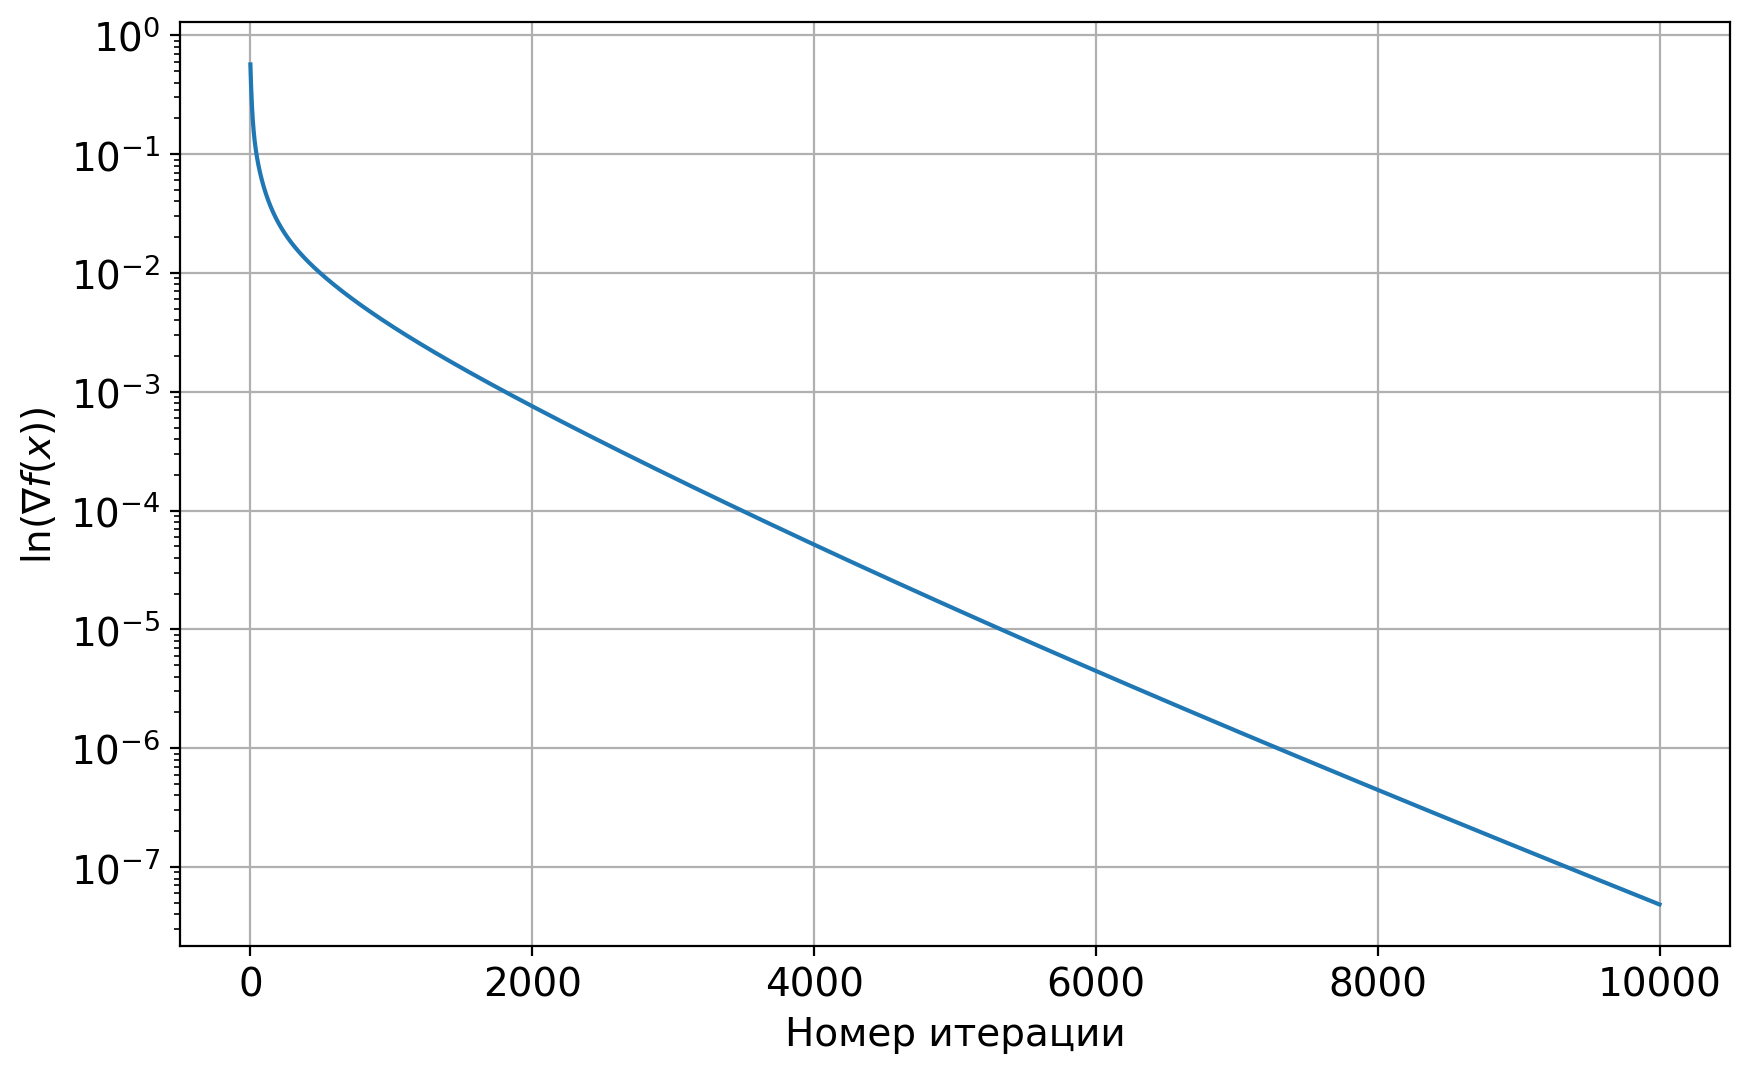

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(grad_log_gd)
plt.xlabel('Номер итерации')
plt.ylabel(r'$\ln(\nabla f(x))$')
plt.grid()
plt.yscale('log')
plt.show()

Посчитаем accuracy.

Перед этим выберем лучший трешхолд на основе train.

In [147]:
from sklearn.metrics import accuracy_score

algorithms = ['gd', 'armijo', 'nesterov']

w = {"gd":w_gd, "armijo":w_armijo, "nesterov":w_nesterov}
best_thresholds = {}

for algorithm in algorithms:
    thresholds = np.linspace(0.1, 0.9, 9)
    acuracies = []
    for threshold in thresholds:
        y_pred = 2 * (1 / (1 + np.exp(-X_train @ w[algorithm])) >= threshold).astype(int) - 1
        acuracies.append(accuracy_score(y_train, y_pred))

    best_threshold = thresholds[np.argmax(acuracies)]
    best_thresholds[algorithm] = (best_threshold, acuracies[np.argmax(acuracies)])

for algorithm, (threshold, accuracy) in best_thresholds.items():
    print(f"{algorithm.capitalize()} Best threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}")

Gd Best threshold: 0.60, Accuracy: 0.9909
Armijo Best threshold: 0.60, Accuracy: 0.9909
Nesterov Best threshold: 0.60, Accuracy: 0.9909


Теперь посмотрим на результат на валидации

In [148]:
for method, tmp_w in w.items():
    threshold = best_thresholds[method][0]
    y_pred = 2 * (1 / (1 + np.exp(-X_test @ tmp_w)) >= threshold).astype(int) - 1
    valid_accuracy = accuracy_score(y_test, y_pred)
    print(f"Validation accuracy for {method}: {valid_accuracy:.4f}")

Validation accuracy for gd: 0.9926
Validation accuracy for armijo: 0.9926
Validation accuracy for nesterov: 0.9926


5)

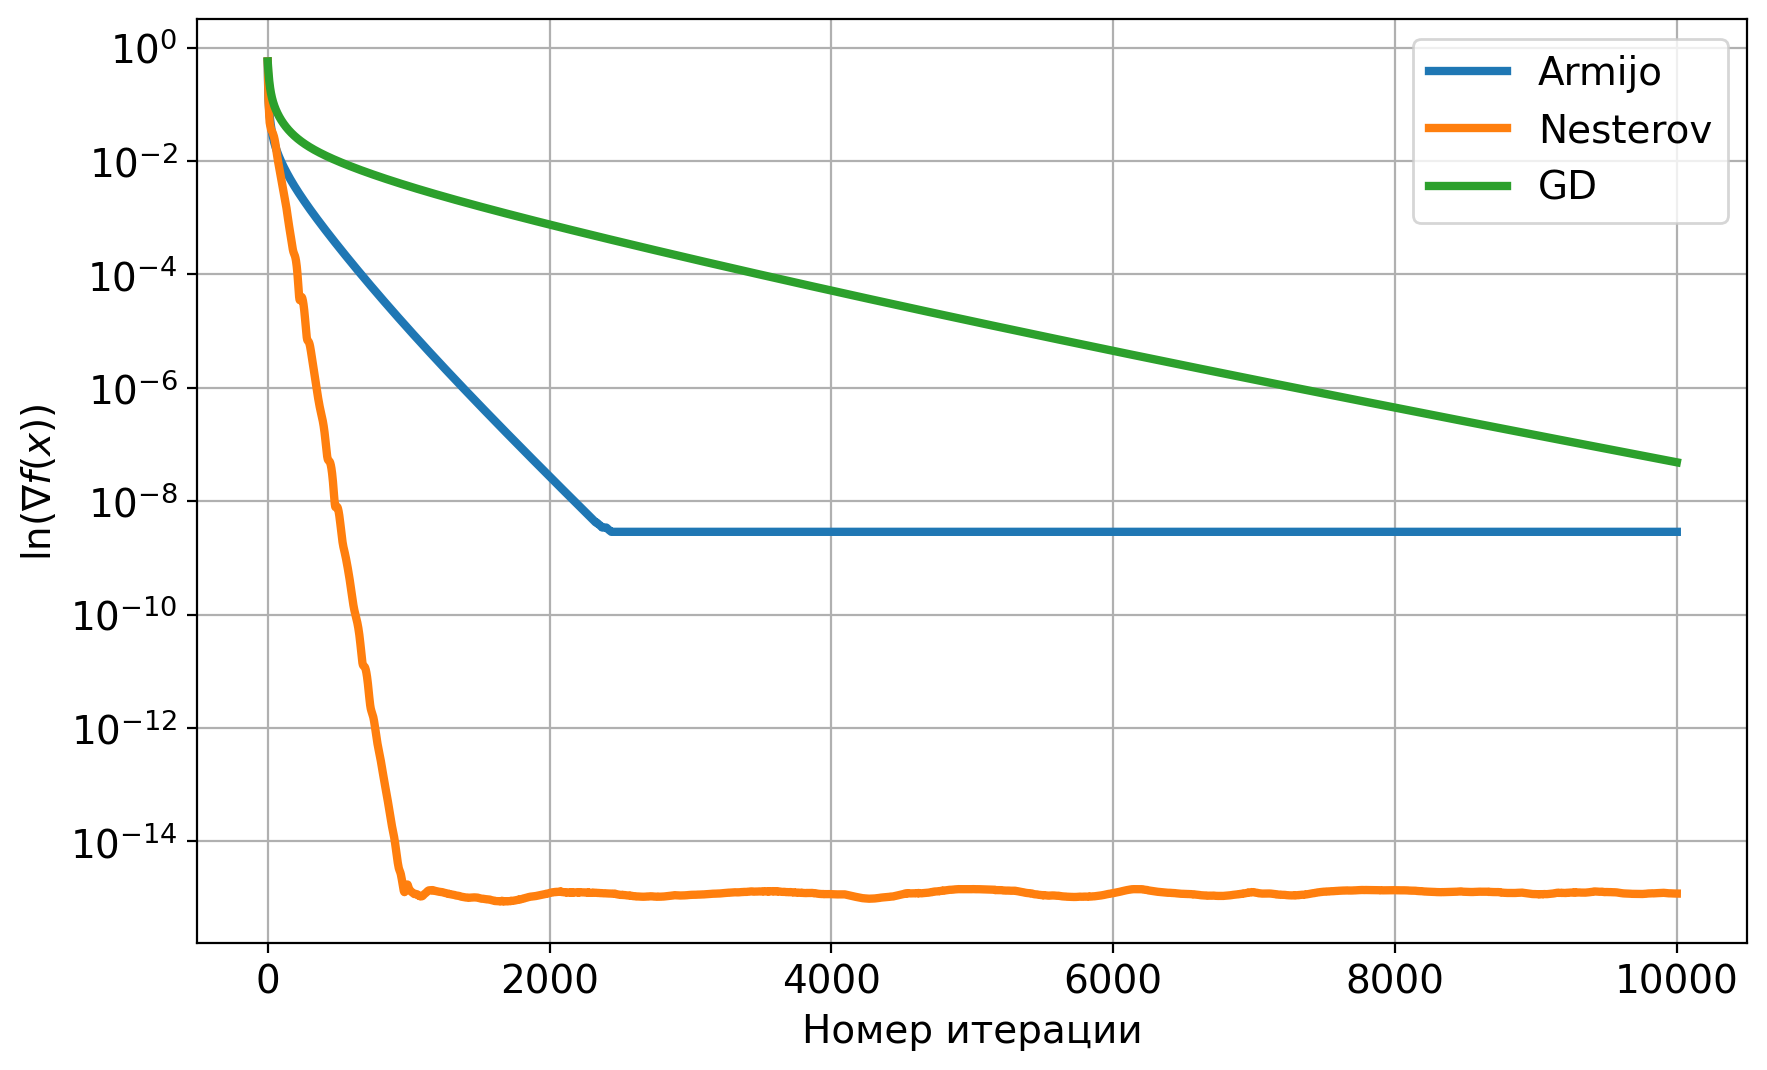

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(grad_log_armijo, label='Armijo', lw=3)
plt.plot(grad_log_nesterov, label='Nesterov', lw=3)
plt.plot(grad_log_gd, label='GD', lw=3)
plt.xlabel('Номер итерации')
plt.ylabel(r'$\ln(\nabla f(x))$')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

6)

In [150]:
alpha = 0
train_logistic_regression = lambda w: logistic_regression(X_train, y_train, alpha, w)
grad_train_logistic_regression = lambda w: gradient_logistic_regression(
    X_train, y_train, alpha, w
)

x0 = np.zeros(X_train.shape[1])
x_star = np.zeros(X_train.shape[1])
w_gd, grad_log_gd, _, dist_gd, iter_log_gd = gd(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    iters,
)

w_nesterov, grad_log_nesterov, _, dist_nesterov, iter_log_nesterov = nesterov(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    0.9,
    iters,
)

x0 = np.zeros(X_train.shape[1])
x_star = np.zeros(X_train.shape[1])
w_armijo, grad_log_armijo, _, dist_armijo, iter_log_armijo = gd(
    train_logistic_regression,
    grad_train_logistic_regression,
    x0,
    x_star,
    1 / L,
    iters,
    use_armijo=True,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

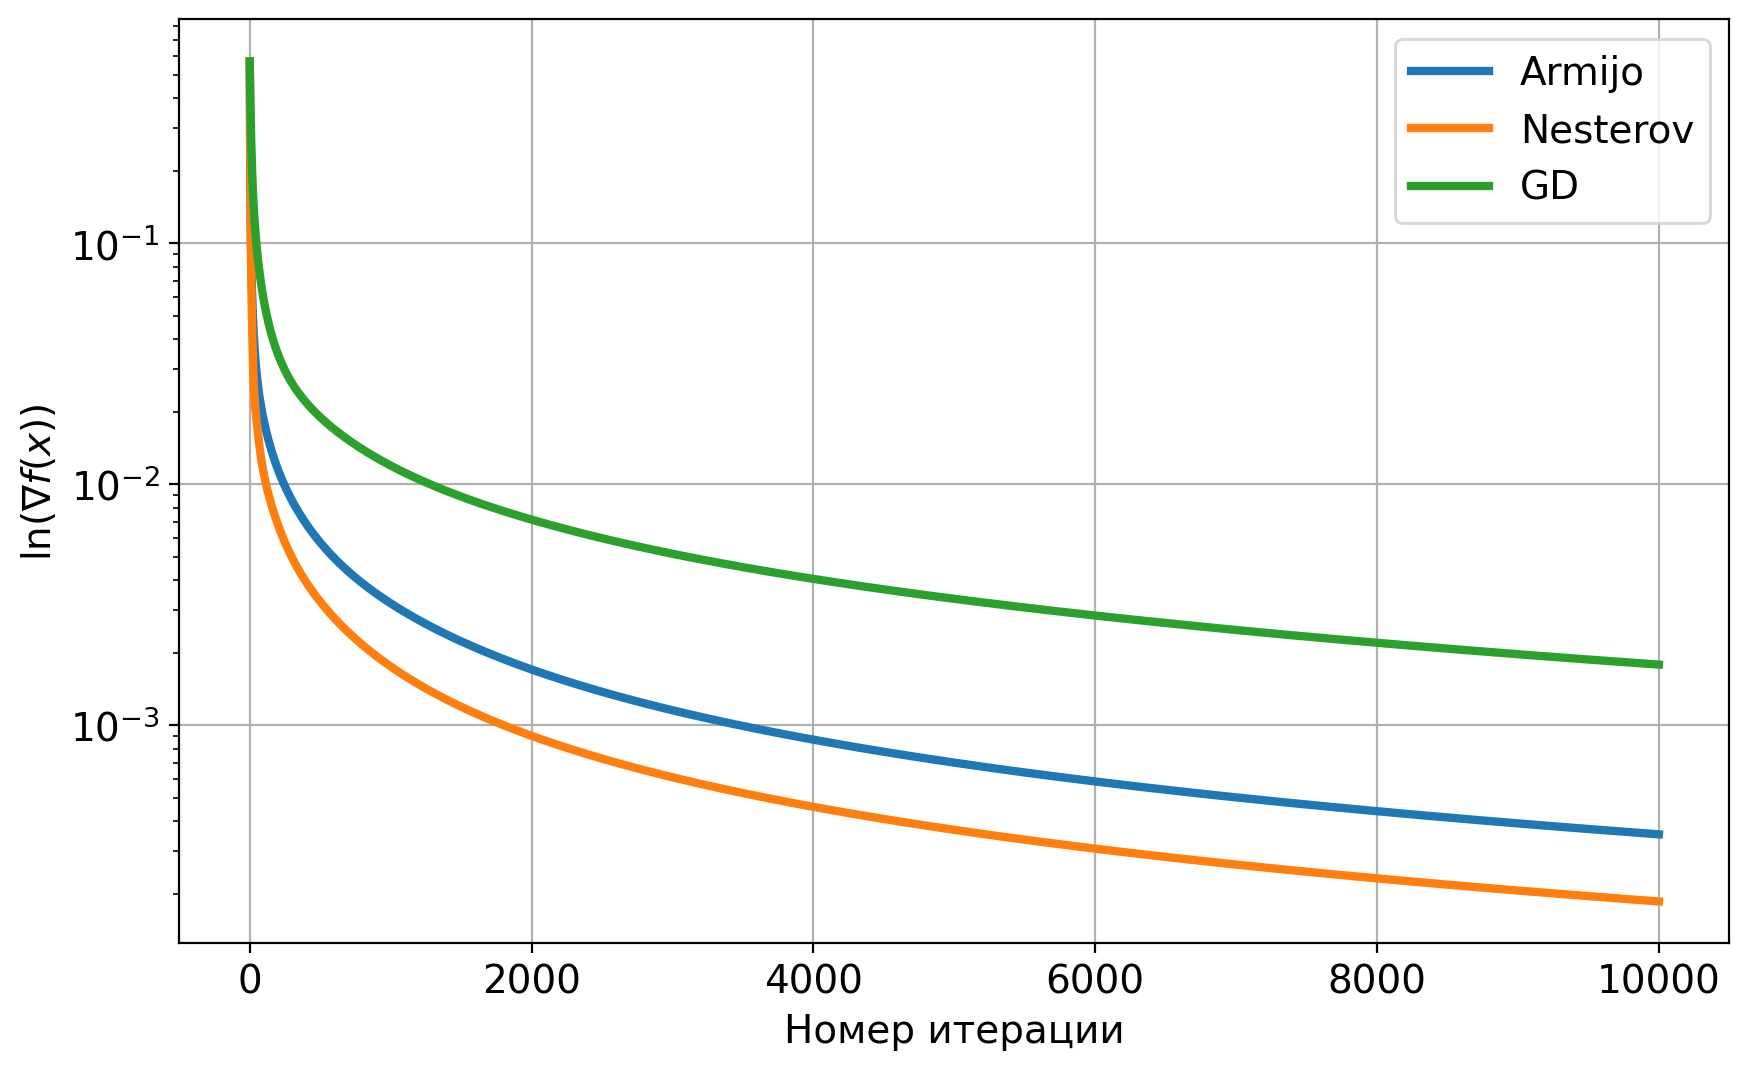

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(grad_log_armijo, label='Armijo', lw=3)
plt.plot(grad_log_nesterov, label='Nesterov', lw=3)
plt.plot(grad_log_gd, label='GD', lw=3)
plt.xlabel('Номер итерации')
plt.ylabel(r'$\ln(\nabla f(x))$')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

Как видим, при отсутствии регуляризации наши методы начинают сходиться медленнее.